In [305]:
!date

Mon Feb 10 00:15:58 JST 2020


In [306]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as ss
import arviz as az

# Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from termcolor import colored

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import seaborn as sns
clrs = sns.color_palette("Spectral", 6)
def set_plot_style(usetex=False):
    sns.set_style('white', {'axes.linewidth': 0.5})
    sns.set(style='white', font_scale=1.1,#context='paper',
            rc={'xtick.major.size': 6, 'ytick.major.size': 6, 'legend.fontsize': 14,
                'text.usetex': usetex, 'font.family': 'serif', 'font.serif': ['Verdana'],
                'text.latex.preamble': r"\usepackage{type1cm}"}) 
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
set_plot_style()
    
import warnings
warnings.filterwarnings('ignore')

func_dict = {"q2.5": lambda x: np.percentile(x, 2.5), 
             "q25": lambda x: np.percentile(x, 25), 
             "median": lambda x: np.percentile(x, 50), 
             "q75": lambda x: np.percentile(x, 75), 
             "q97.5": lambda x: np.percentile(x, 97.5)}

!mkdir -p ../../results/Andrei/MCMC

In [307]:
def get_stats(cmdstan_data):
    # include mean and hpd
    stats = az.summary(cmdstan_data,credible_interval=0.95).loc[:, ['mean','hpd_2.5%','hpd_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hpd_2.5%':'hpd2.5', 'hpd_97.5%':'hpd97.5'})
    stats = az.summary(cmdstan_data,credible_interval=0.50).loc[:, ['hpd_25%','hpd_75%']].reset_index().rename(columns={'index':'var', 'hpd_25%':'hpd25', 'hpd_75%':'hpd75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hpd2.5','hpd25','hpd75','hpd97.5','q2.5','q25','median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

# Processing the traces

In [62]:
dirs = !ls -d ../../results/Stan-sims/*data*trunc*
dirs

['../../results/Stan-sims/data_incper-gamma-no_truncation',
 '../../results/Stan-sims/data_incper_inclwuhan-gamma-no_truncation',
 '../../results/Stan-sims/data_incper_inclwuhan-lognormal-no_truncation',
 '../../results/Stan-sims/data_incper_inclwuhan-weibull-no_truncation',
 '../../results/Stan-sims/data_incper-lognormal-no_truncation',
 '../../results/Stan-sims/data_incper-lognormal-truncated',
 '../../results/Stan-sims/data_incper-weibull-no_truncation',
 '../../results/Stan-sims/data_ons_hosp-gamma-no_truncation',
 '../../results/Stan-sims/data_ons_hosp-lognormal-no_truncation',
 '../../results/Stan-sims/data_ons_hosp-weibull-no_truncation',
 '../../results/Stan-sims/dthdata_hosp_dth-gamma-no_truncation',
 '../../results/Stan-sims/dthdata_hosp_dth-lognormal-no_truncation',
 '../../results/Stan-sims/dthdata_hosp_dth-weibull-no_truncation',
 '../../results/Stan-sims/dthdata_ons_dth-gamma-no_truncation',
 '../../results/Stan-sims/dthdata_ons_dth-lognormal-no_truncation',
 '../../resul

In [65]:
datasets = np.unique([folder.split("/")[-1].split("-")[0] for folder in dirs])
datasets

array(['data_incper', 'data_incper_inclwuhan', 'data_ons_hosp',
       'dthdata_hosp_dth', 'dthdata_ons_dth', 'dthdata_ons_hosp'],
      dtype='<U21')

In [66]:
distribs = np.unique([folder.split("/")[-1].split("-")[1] for folder in dirs])
distribs

array(['gamma', 'lognormal', 'weibull'], dtype='<U9')

In [67]:
truncations = np.unique([folder.split("/")[-1].split("-")[2] for folder in dirs])
truncations

array(['no_truncation', 'truncated'], dtype='<U13')

# Particular folder - test

data_incper_inclwuhan-gamma-no_truncation


Dataset Distribution     Truncation            mean  \
0  data_incper_inclwuhan        gamma  no_truncation  5.1 (4.5, 5.7)   

               SD              q5          median               q95  \
0  2.8 (2.3, 3.5)  1.4 (1.0, 2.0)  4.5 (4.0, 5.1)  10.4 (9.2, 12.1)   

                 q99  
0  13.8 (11.9, 16.5)

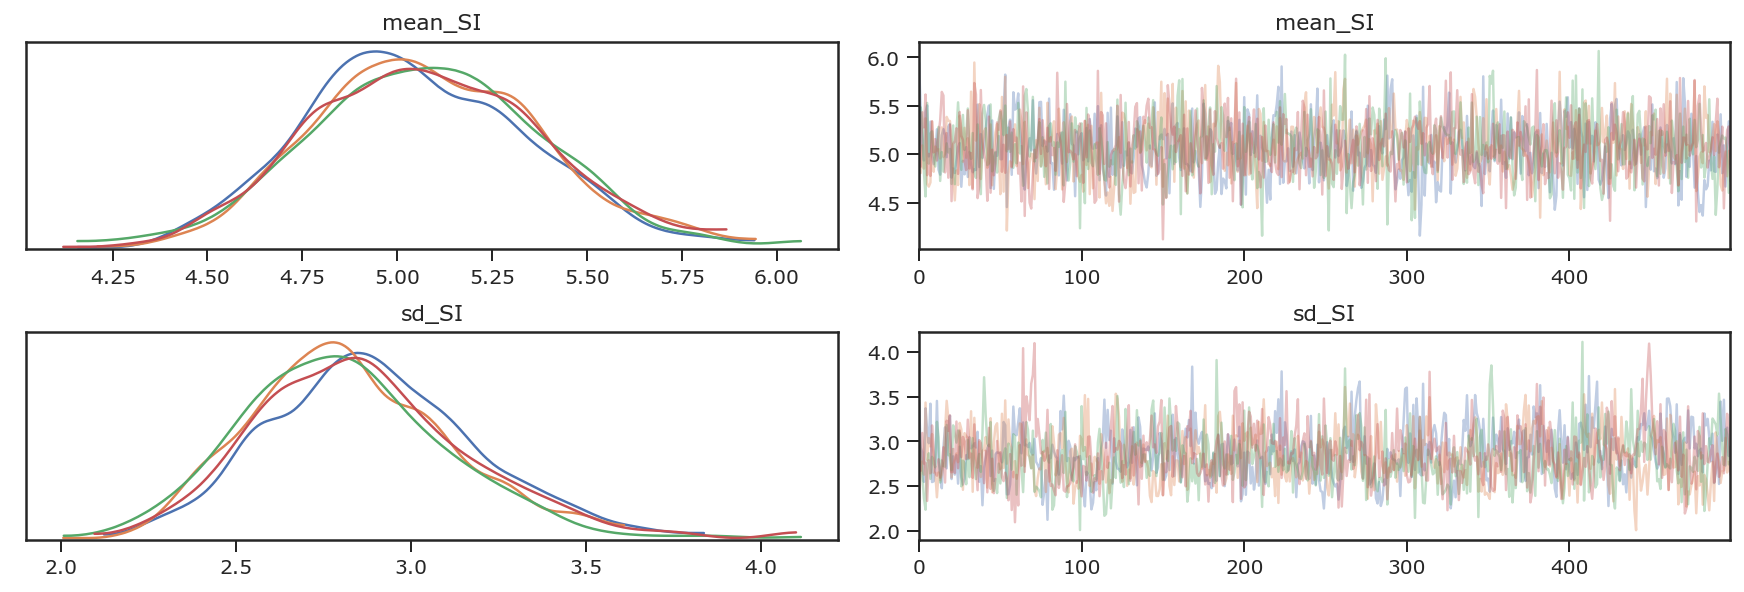

In [27]:
# folder = "data_incper_inclwuhan-gamma-no_truncation"
# dataset, distrib, truncation_type = folder.split("-")

# print(colored(folder, 'red'))

# posterior_glob = !ls ./{folder}/trace-*

# cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
# param1 = cmdstan_data.posterior.param1.values.ravel()
# param2 = cmdstan_data.posterior.param2.values.ravel()
# cmdstan_stats = get_stats(cmdstan_data)  

# df_ = cmdstan_stats
# meanSI_ = df_.loc[lambda d: d['var']=='mean_SI',['mean','q2.5','q97.5']].values[0]
# sdSI_ = df_.loc[lambda d: d['var']=='sd_SI',['mean','q2.5','q97.5']].values[0]

# if distrib=='gamma':
#     # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
#     y = np.percentile(np.stack([ss.gamma(param1[idx],scale=1/param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(1000)]).T,[50,2.5,97.5],axis=1)
# elif distrib=='weibull':
#     # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html
#     y = np.percentile(np.stack([ss.weibull_min(param1[idx],scale=param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(1000)]).T,[50,2.5,97.5],axis=1)
# elif distrib=='lognormal':
#     # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
#     y = np.percentile(np.stack([ss.lognorm(param2[idx],scale=np.exp(param1[idx])).ppf([.05,.5,.95,.99]).tolist() for idx in range(1000)]).T,[50,2.5,97.5],axis=1)
# output_ = [dataset,distrib,truncation_type,
#       '%.1f (%.1f, %.1f)'%(meanSI_[0],meanSI_[1],meanSI_[2]),
#       '%.1f (%.1f, %.1f)'%(sdSI_[0],sdSI_[1],sdSI_[2]),
#       '%.1f (%.1f, %.1f)'%(y[:,0][0],y[:,0][1],y[:,0][2]),
#       '%.1f (%.1f, %.1f)'%(y[:,1][0],y[:,1][1],y[:,1][2]), 
#       '%.1f (%.1f, %.1f)'%(y[:,2][0],y[:,2][1],y[:,2][2]), 
#       '%.1f (%.1f, %.1f)'%(y[:,3][0],y[:,3][1],y[:,3][2])]

# az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
# plt.savefig("../../results/Andrei/MCMC/trace-"+folder+".pdf", format='pdf')

# pd.DataFrame([output_],columns=['Dataset', 'Distribution', 'Truncation', 'mean', 'SD', 'q5', 'median', 'q95', 'q99'])

# No truncation

data_incper-gamma-no_truncation
['data_incper', 'gamma', 'no_truncation', '5.0 (4.1, 5.9)', '3.5 (2.7, 4.6)', '0.9 (0.5, 1.4)', '4.2 (3.3, 5.0)', '11.6 (9.5, 14.6)', '16.1 (13.0, 21.1)']
data_incper-lognormal-no_truncation
['data_incper', 'lognormal', 'no_truncation', '4.6 (3.8, 5.7)', '3.9 (2.5, 6.4)', '1.1 (0.6, 1.7)', '3.5 (2.7, 4.4)', '11.5 (8.8, 16.3)', '18.8 (13.1, 31.2)']
data_incper-weibull-no_truncation
['data_incper', 'weibull', 'no_truncation', '4.7 (3.7, 5.8)', '4.2 (3.1, 6.1)', '0.4 (0.1, 0.8)', '3.6 (2.5, 4.6)', '12.7 (10.0, 17.6)', '18.4 (13.9, 28.5)']


Distribution   waic  d_waic  weight      Dataset     Truncation  \
0    lognormal  360.0    0.00   0.550  data_incper  no_truncation   
1        gamma  361.1    1.03   0.448  data_incper  no_truncation   
2      weibull  373.1   13.03   0.001  data_incper  no_truncation   

             mean              SD              q5          median  \
0  4.6 (3.8, 5.7)  3.9 (2.5, 6.4)  1.1 (0.6, 1.7)  3.5 (2.7, 4.4)   
1  5.0 (4.1, 5.9)  3.5 (2.7, 4.6)  0.9 (0.5, 1.4)  4.2 (3.3, 5.0)   
2  4.7 (3.7, 5.8)  4.2 (3.1, 6.1)  0.4 (0.1, 0.8)  3.6 (2.5, 4.6)   

                 q95                q99  
0   11.5 (8.8, 16.3)  18.8 (13.1, 31.2)  
1   11.6 (9.5, 14.6)  16.1 (13.0, 21.1)  
2  12.7 (10.0, 17.6)  18.4 (13.9, 28.5)

data_incper_inclwuhan-gamma-no_truncation
['data_incper_inclwuhan', 'gamma', 'no_truncation', '5.1 (4.5, 5.7)', '3.1 (2.6, 3.8)', '1.2 (0.8, 1.6)', '4.4 (3.8, 5.0)', '11.0 (9.6, 12.9)', '14.9 (12.8, 18.0)']
data_incper_inclwuhan-lognormal-no_truncation
['data_incper_inclwuhan', 'lognormal', 'no_truncation', '5.0 (4.4, 5.6)', '2.9 (2.2, 3.8)', '1.8 (1.4, 2.3)', '4.3 (3.8, 4.9)', '10.4 (8.9, 12.5)', '14.9 (12.1, 19.2)']
data_incper_inclwuhan-weibull-no_truncation
['data_incper_inclwuhan', 'weibull', 'no_truncation', '5.1 (4.5, 5.8)', '3.2 (2.7, 3.8)', '1.0 (0.6, 1.4)', '4.6 (3.9, 5.3)', '11.0 (9.7, 12.8)', '14.3 (12.3, 17.1)']


Distribution   waic  d_waic  weight                Dataset     Truncation  \
0    lognormal  944.7    0.00     1.0  data_incper_inclwuhan  no_truncation   
1        gamma  974.9   30.19     0.0  data_incper_inclwuhan  no_truncation   
2      weibull  984.9   40.16     0.0  data_incper_inclwuhan  no_truncation   

             mean              SD              q5          median  \
0  5.0 (4.4, 5.6)  2.9 (2.2, 3.8)  1.8 (1.4, 2.3)  4.3 (3.8, 4.9)   
1  5.1 (4.5, 5.7)  3.1 (2.6, 3.8)  1.2 (0.8, 1.6)  4.4 (3.8, 5.0)   
2  5.1 (4.5, 5.8)  3.2 (2.7, 3.8)  1.0 (0.6, 1.4)  4.6 (3.9, 5.3)   

                q95                q99  
0  10.4 (8.9, 12.5)  14.9 (12.1, 19.2)  
1  11.0 (9.6, 12.9)  14.9 (12.8, 18.0)  
2  11.0 (9.7, 12.8)  14.3 (12.3, 17.1)

data_ons_hosp-gamma-no_truncation
['data_ons_hosp', 'gamma', 'no_truncation', '3.2 (2.6, 4.0)', '4.2 (3.3, 5.4)', '0.0 (0.0, 0.1)', '1.7 (1.2, 2.2)', '11.4 (9.3, 14.7)', '19.1 (15.1, 25.1)']
data_ons_hosp-lognormal-no_truncation
['data_ons_hosp', 'lognormal', 'no_truncation', '3.8 (2.9, 5.1)', '8.3 (4.9, 14.2)', '0.2 (0.1, 0.3)', '1.6 (1.2, 2.0)', '13.6 (10.1, 19.2)', '33.0 (22.4, 52.2)']
data_ons_hosp-weibull-no_truncation
['data_ons_hosp', 'weibull', 'no_truncation', '3.3 (2.7, 4.1)', '4.2 (3.2, 5.7)', '0.1 (0.0, 0.1)', '1.8 (1.4, 2.3)', '11.4 (9.1, 14.9)', '19.5 (14.9, 27.4)']


Distribution   waic  d_waic  weight        Dataset     Truncation  \
0        gamma  528.4    0.00     1.0  data_ons_hosp  no_truncation   
1      weibull  663.1  134.65     0.0  data_ons_hosp  no_truncation   
2    lognormal  693.8  165.43     0.0  data_ons_hosp  no_truncation   

             mean               SD              q5          median  \
0  3.2 (2.6, 4.0)   4.2 (3.3, 5.4)  0.0 (0.0, 0.1)  1.7 (1.2, 2.2)   
1  3.3 (2.7, 4.1)   4.2 (3.2, 5.7)  0.1 (0.0, 0.1)  1.8 (1.4, 2.3)   
2  3.8 (2.9, 5.1)  8.3 (4.9, 14.2)  0.2 (0.1, 0.3)  1.6 (1.2, 2.0)   

                 q95                q99  
0   11.4 (9.3, 14.7)  19.1 (15.1, 25.1)  
1   11.4 (9.1, 14.9)  19.5 (14.9, 27.4)  
2  13.6 (10.1, 19.2)  33.0 (22.4, 52.2)

dthdata_hosp_dth-gamma-no_truncation
['dthdata_hosp_dth', 'gamma', 'no_truncation', '8.7 (7.0, 10.8)', '6.0 (4.6, 8.1)', '1.6 (0.9, 2.5)', '7.2 (5.7, 9.1)', '20.1 (16.1, 26.3)', '27.9 (21.9, 37.7)']
dthdata_hosp_dth-lognormal-no_truncation
['dthdata_hosp_dth', 'lognormal', 'no_truncation', '8.6 (6.8, 10.8)', '6.7 (4.6, 10.3)', '2.2 (1.4, 3.0)', '6.7 (5.3, 8.3)', '20.5 (15.7, 28.8)', '32.6 (23.4, 50.4)']
dthdata_hosp_dth-weibull-no_truncation
['dthdata_hosp_dth', 'weibull', 'no_truncation', '8.6 (7.0, 10.4)', '5.4 (4.2, 7.2)', '1.6 (0.8, 2.5)', '7.7 (5.9, 9.5)', '18.5 (15.4, 23.8)', '24.1 (19.5, 32.6)']


Distribution   waic  d_waic  weight           Dataset     Truncation  \
0      weibull  236.1    0.00   0.446  dthdata_hosp_dth  no_truncation   
1        gamma  236.1    0.02   0.414  dthdata_hosp_dth  no_truncation   
2    lognormal  240.1    4.00   0.141  dthdata_hosp_dth  no_truncation   

              mean               SD              q5          median  \
0  8.6 (7.0, 10.4)   5.4 (4.2, 7.2)  1.6 (0.8, 2.5)  7.7 (5.9, 9.5)   
1  8.7 (7.0, 10.8)   6.0 (4.6, 8.1)  1.6 (0.9, 2.5)  7.2 (5.7, 9.1)   
2  8.6 (6.8, 10.8)  6.7 (4.6, 10.3)  2.2 (1.4, 3.0)  6.7 (5.3, 8.3)   

                 q95                q99  
0  18.5 (15.4, 23.8)  24.1 (19.5, 32.6)  
1  20.1 (16.1, 26.3)  27.9 (21.9, 37.7)  
2  20.5 (15.7, 28.8)  32.6 (23.4, 50.4)

dthdata_ons_dth-gamma-no_truncation
['dthdata_ons_dth', 'gamma', 'no_truncation', '14.9 (12.3, 18.1)', '8.8 (6.8, 11.6)', '4.0 (2.5, 5.5)', '13.2 (10.7, 16.0)', '31.3 (25.7, 39.8)', '41.8 (33.7, 54.8)']
dthdata_ons_dth-lognormal-no_truncation
['dthdata_ons_dth', 'lognormal', 'no_truncation', '14.6 (12.5, 17.0)', '6.7 (4.9, 9.4)', '6.5 (4.9, 7.9)', '13.2 (11.3, 15.2)', '26.8 (22.3, 34.3)', '36.0 (28.7, 49.1)']
dthdata_ons_dth-weibull-no_truncation
['dthdata_ons_dth', 'weibull', 'no_truncation', '14.8 (12.3, 17.5)', '7.6 (6.2, 9.8)', '3.9 (2.3, 5.7)', '13.9 (11.3, 16.6)', '28.4 (24.3, 34.7)', '35.0 (29.5, 44.3)']


Distribution   waic  d_waic  weight          Dataset     Truncation  \
0    lognormal  221.9    0.00   0.838  dthdata_ons_dth  no_truncation   
1        gamma  227.8    5.89   0.139  dthdata_ons_dth  no_truncation   
2      weibull  231.2    9.34   0.023  dthdata_ons_dth  no_truncation   

                mean               SD              q5             median  \
0  14.6 (12.5, 17.0)   6.7 (4.9, 9.4)  6.5 (4.9, 7.9)  13.2 (11.3, 15.2)   
1  14.9 (12.3, 18.1)  8.8 (6.8, 11.6)  4.0 (2.5, 5.5)  13.2 (10.7, 16.0)   
2  14.8 (12.3, 17.5)   7.6 (6.2, 9.8)  3.9 (2.3, 5.7)  13.9 (11.3, 16.6)   

                 q95                q99  
0  26.8 (22.3, 34.3)  36.0 (28.7, 49.1)  
1  31.3 (25.7, 39.8)  41.8 (33.7, 54.8)  
2  28.4 (24.3, 34.7)  35.0 (29.5, 44.3)

dthdata_ons_hosp-gamma-no_truncation
['dthdata_ons_hosp', 'gamma', 'no_truncation', '6.3 (5.0, 7.9)', '4.3 (3.2, 5.9)', '1.2 (0.6, 1.9)', '5.3 (4.1, 6.7)', '14.3 (11.4, 19.3)', '19.8 (15.4, 27.5)']
dthdata_ons_hosp-lognormal-no_truncation
['dthdata_ons_hosp', 'lognormal', 'no_truncation', '6.2 (5.0, 7.8)', '4.3 (2.9, 6.6)', '1.9 (1.3, 2.5)', '5.1 (4.1, 6.3)', '13.9 (10.7, 19.6)', '21.0 (15.1, 32.6)']
dthdata_ons_hosp-weibull-no_truncation
['dthdata_ons_hosp', 'weibull', 'no_truncation', '6.2 (5.0, 7.7)', '4.0 (3.1, 5.3)', '1.1 (0.6, 1.9)', '5.5 (4.2, 7.0)', '13.5 (11.1, 17.8)', '17.5 (14.1, 24.3)']


Distribution   waic  d_waic  weight           Dataset     Truncation  \
0        gamma  183.3    0.00   0.331  dthdata_ons_hosp  no_truncation   
1    lognormal  183.9    0.62   0.464  dthdata_ons_hosp  no_truncation   
2      weibull  185.4    2.16   0.206  dthdata_ons_hosp  no_truncation   

             mean              SD              q5          median  \
0  6.3 (5.0, 7.9)  4.3 (3.2, 5.9)  1.2 (0.6, 1.9)  5.3 (4.1, 6.7)   
1  6.2 (5.0, 7.8)  4.3 (2.9, 6.6)  1.9 (1.3, 2.5)  5.1 (4.1, 6.3)   
2  6.2 (5.0, 7.7)  4.0 (3.1, 5.3)  1.1 (0.6, 1.9)  5.5 (4.2, 7.0)   

                 q95                q99  
0  14.3 (11.4, 19.3)  19.8 (15.4, 27.5)  
1  13.9 (10.7, 19.6)  21.0 (15.1, 32.6)  
2  13.5 (11.1, 17.8)  17.5 (14.1, 24.3)

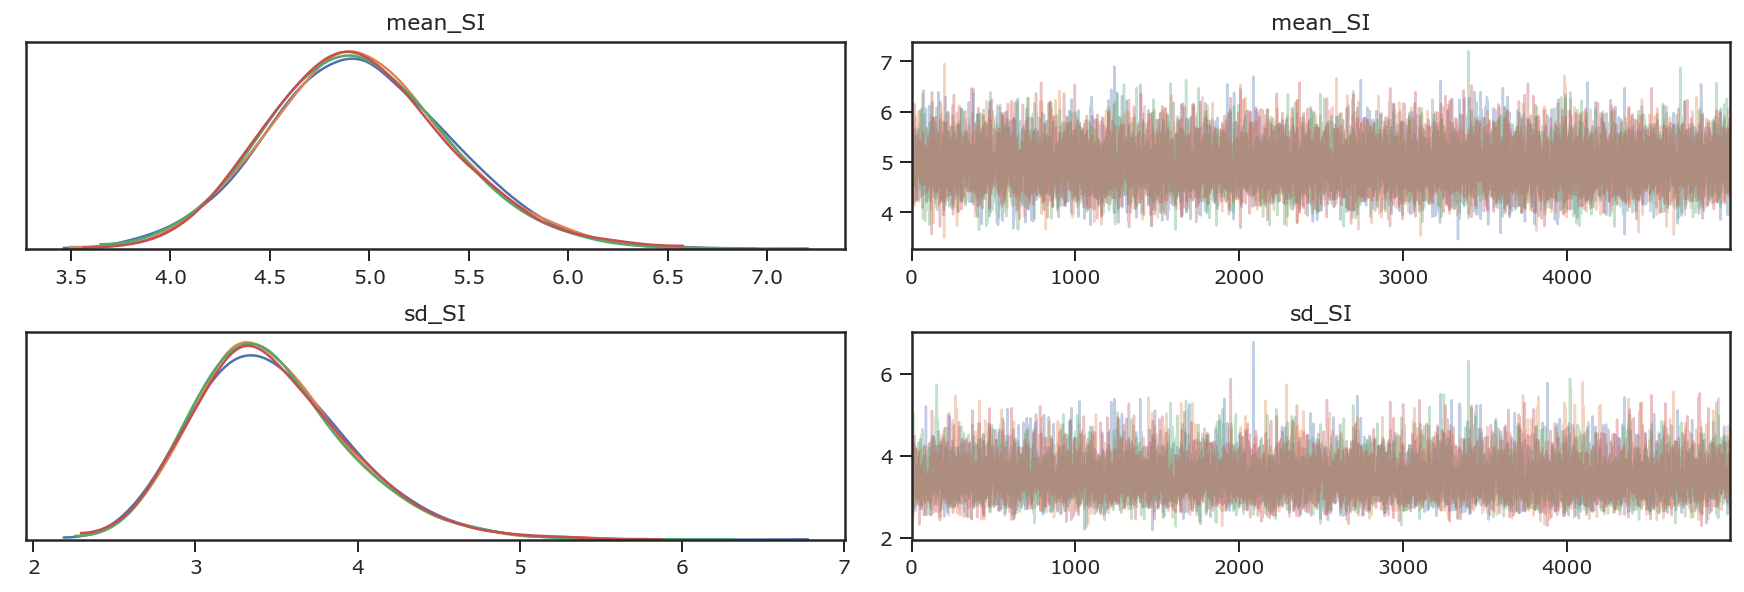

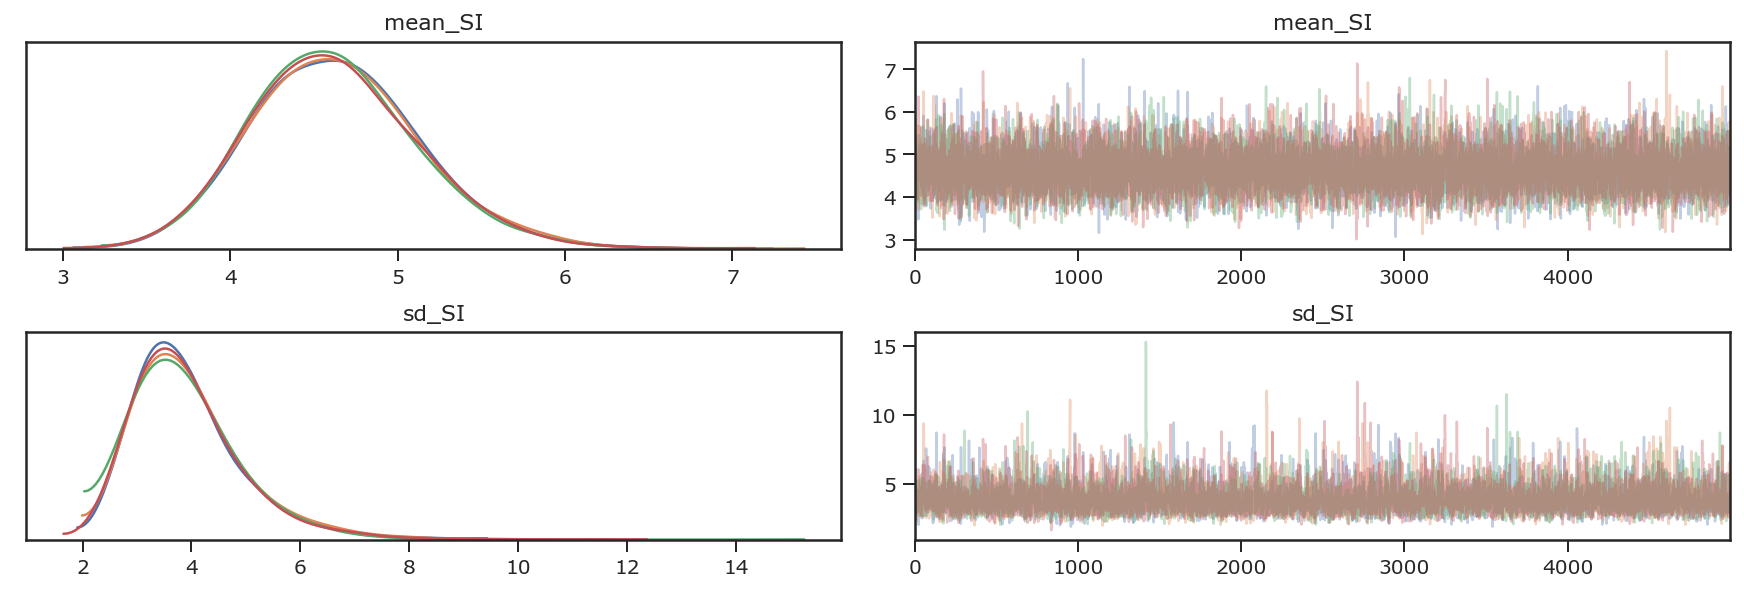

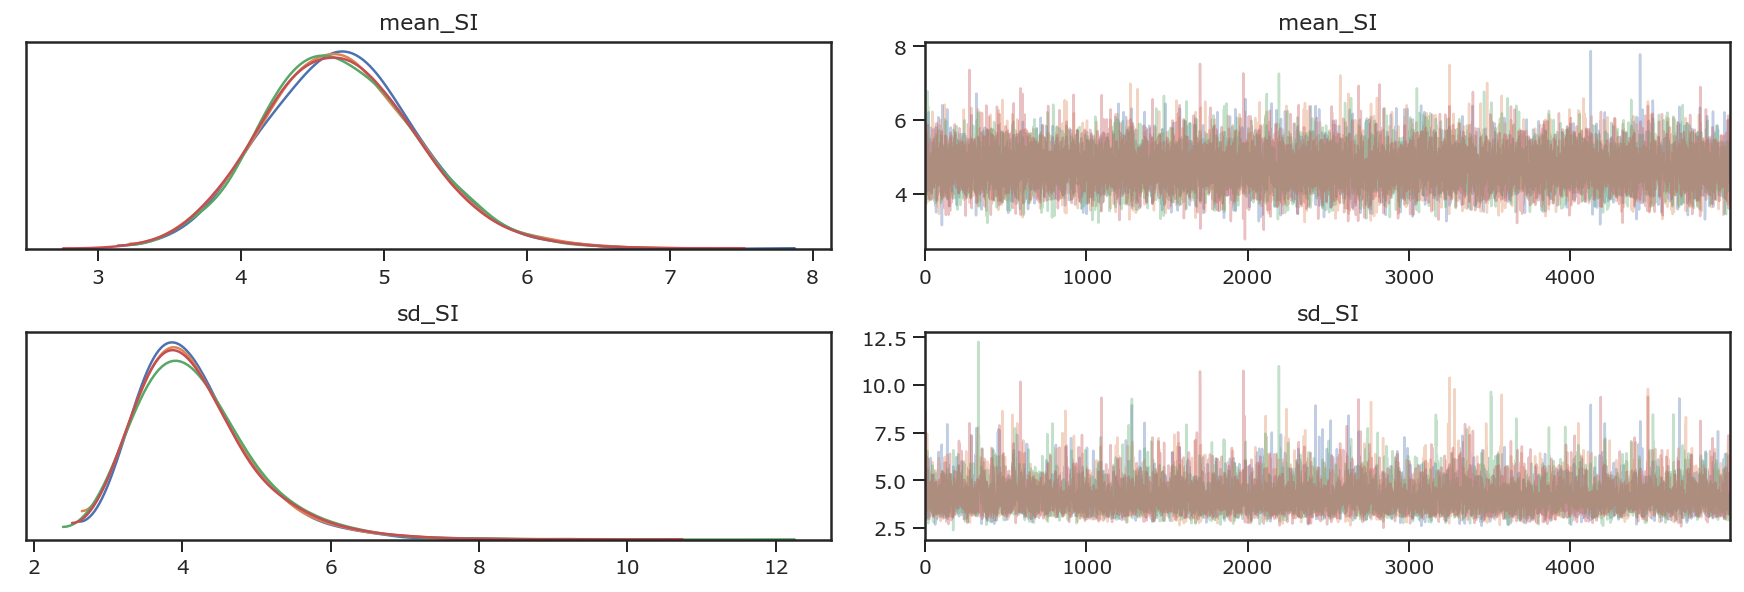

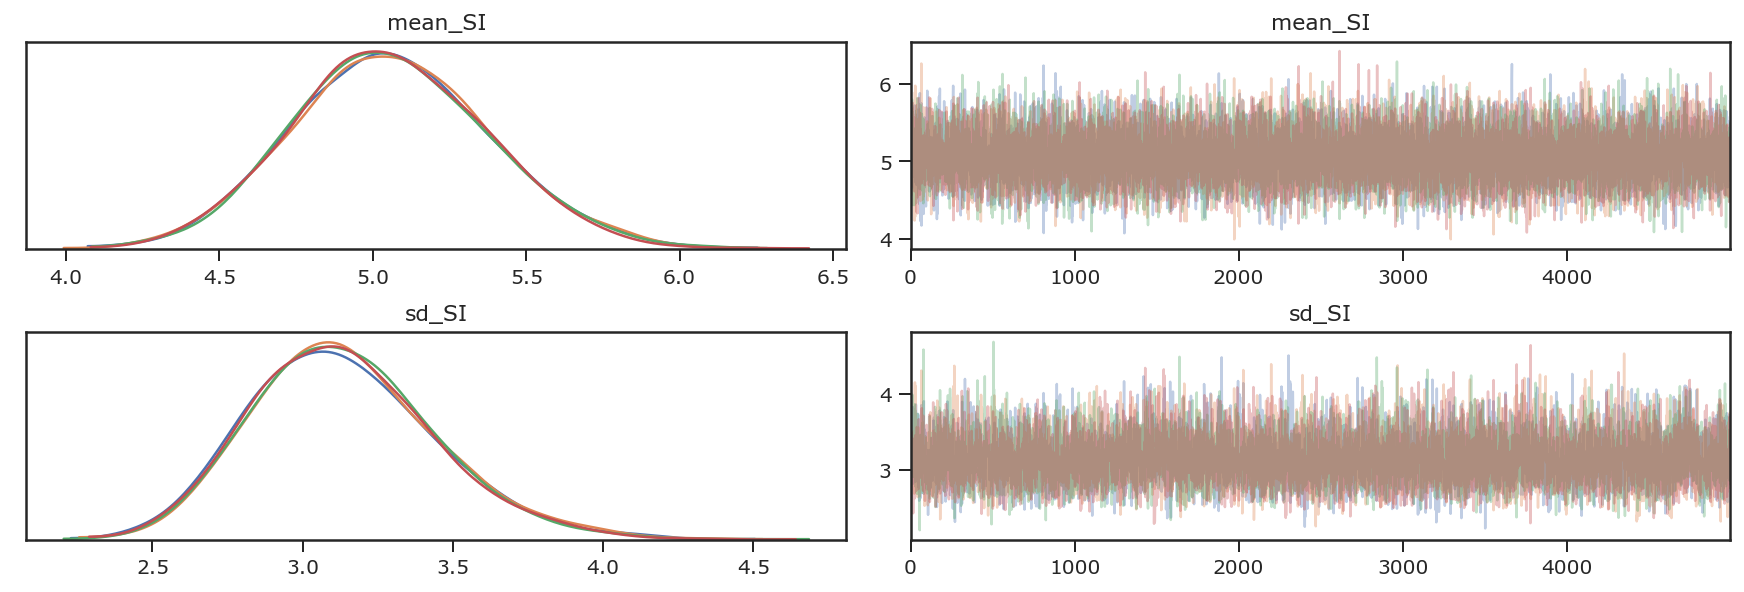

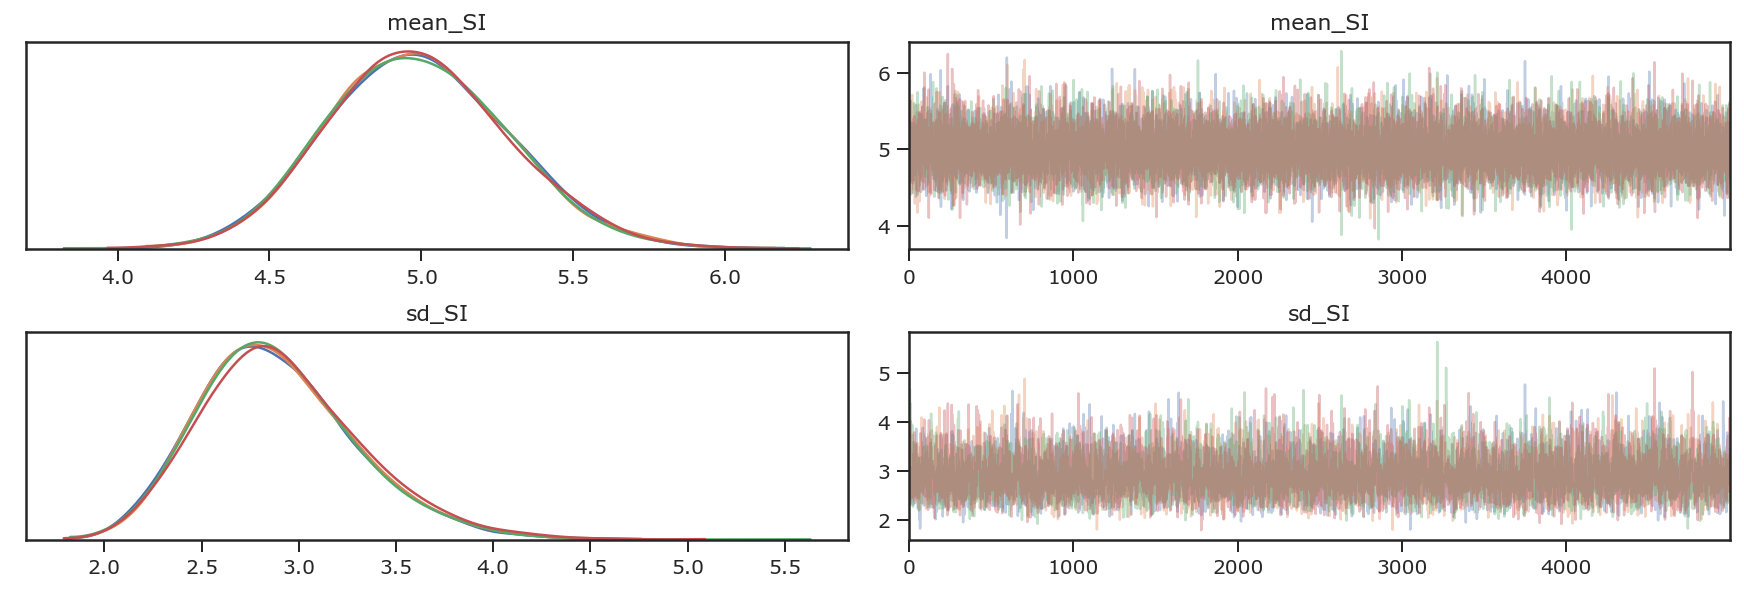

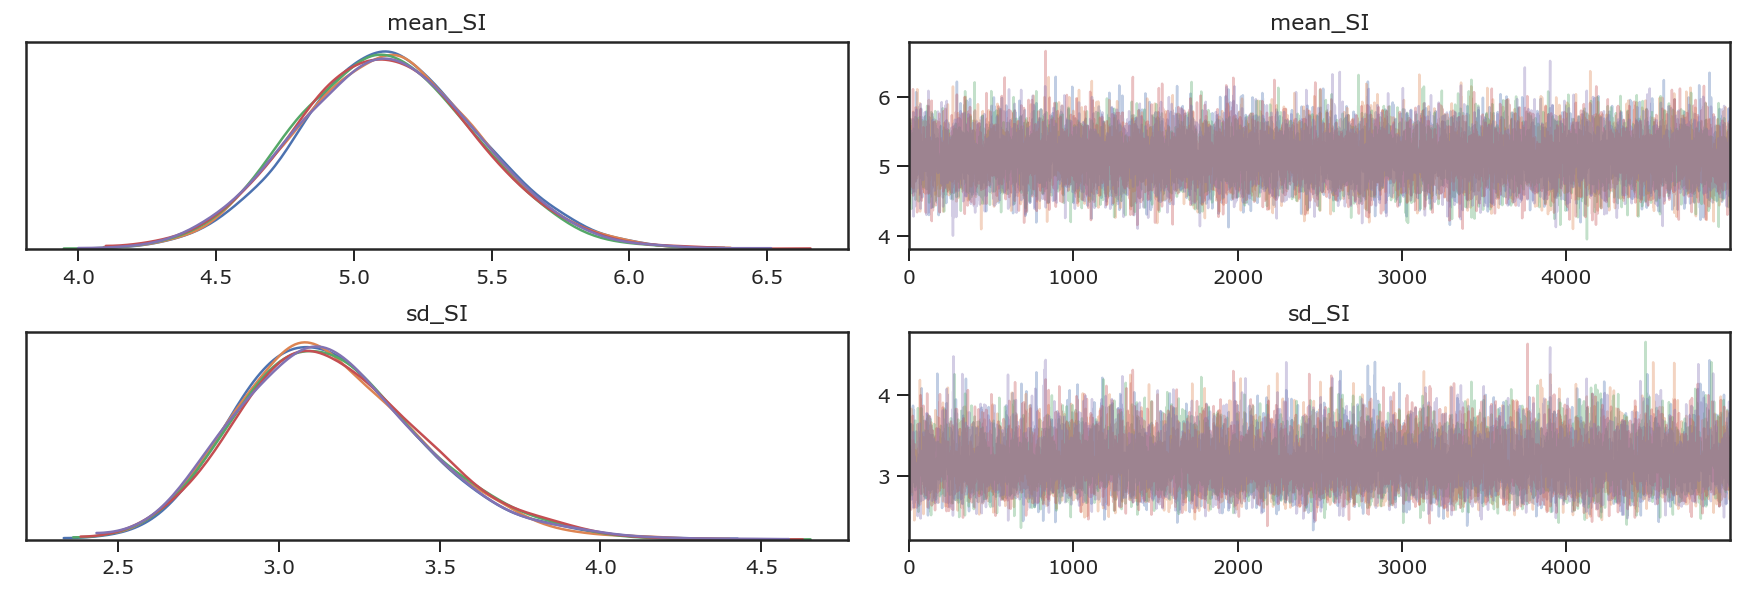

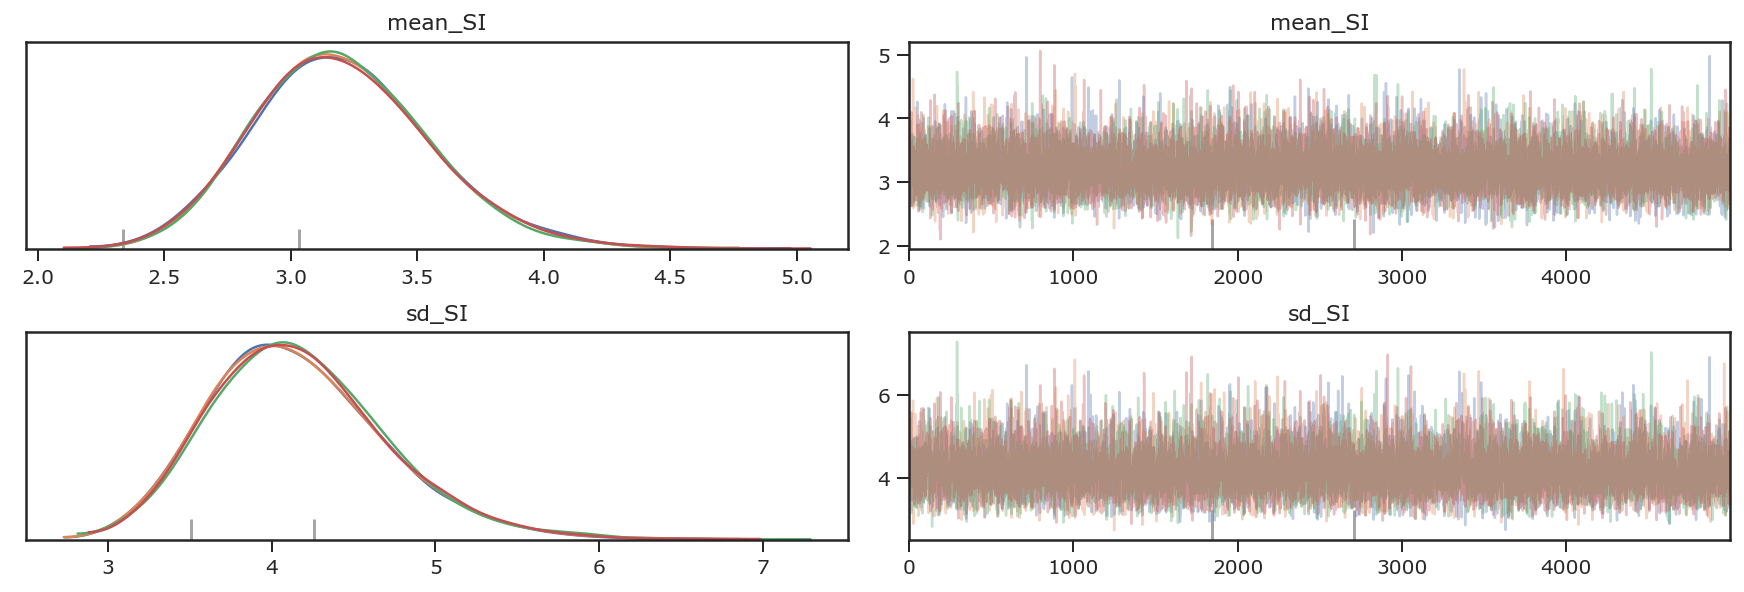

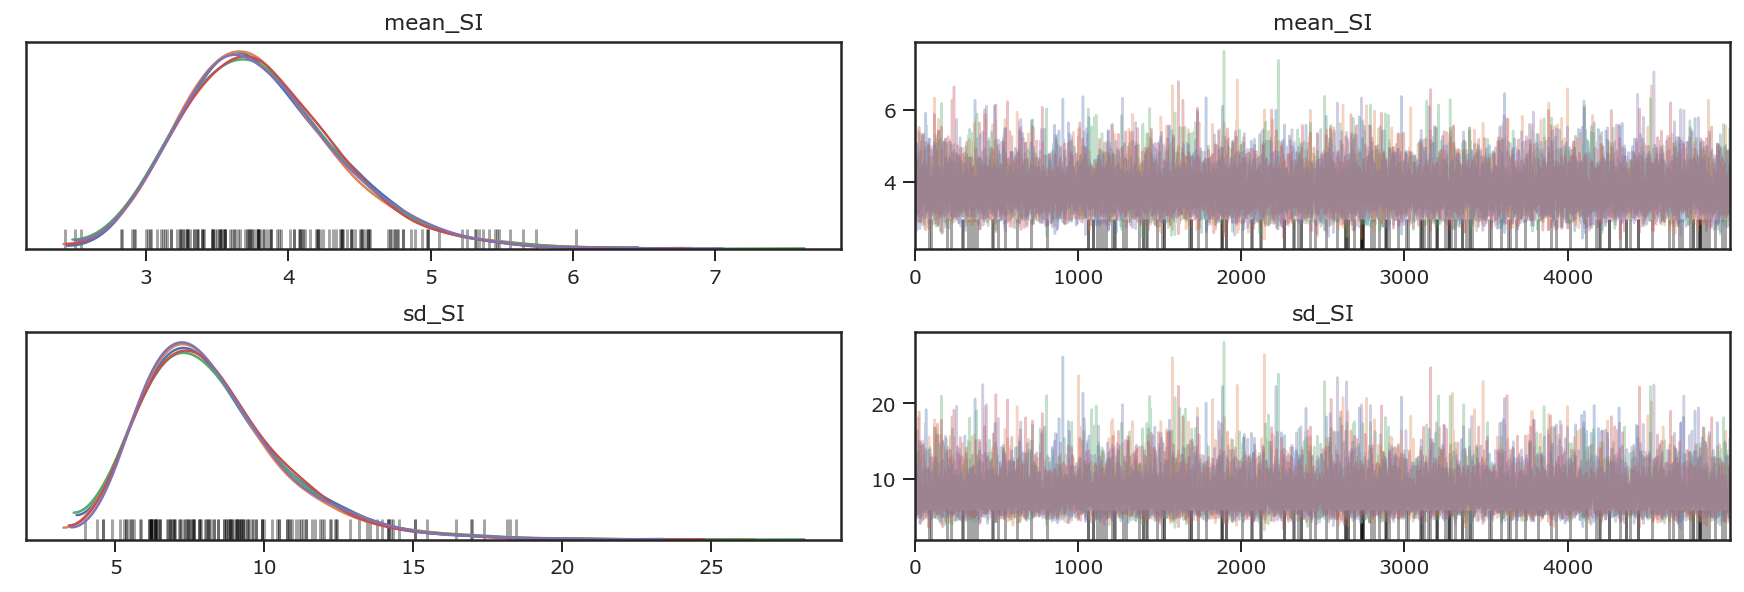

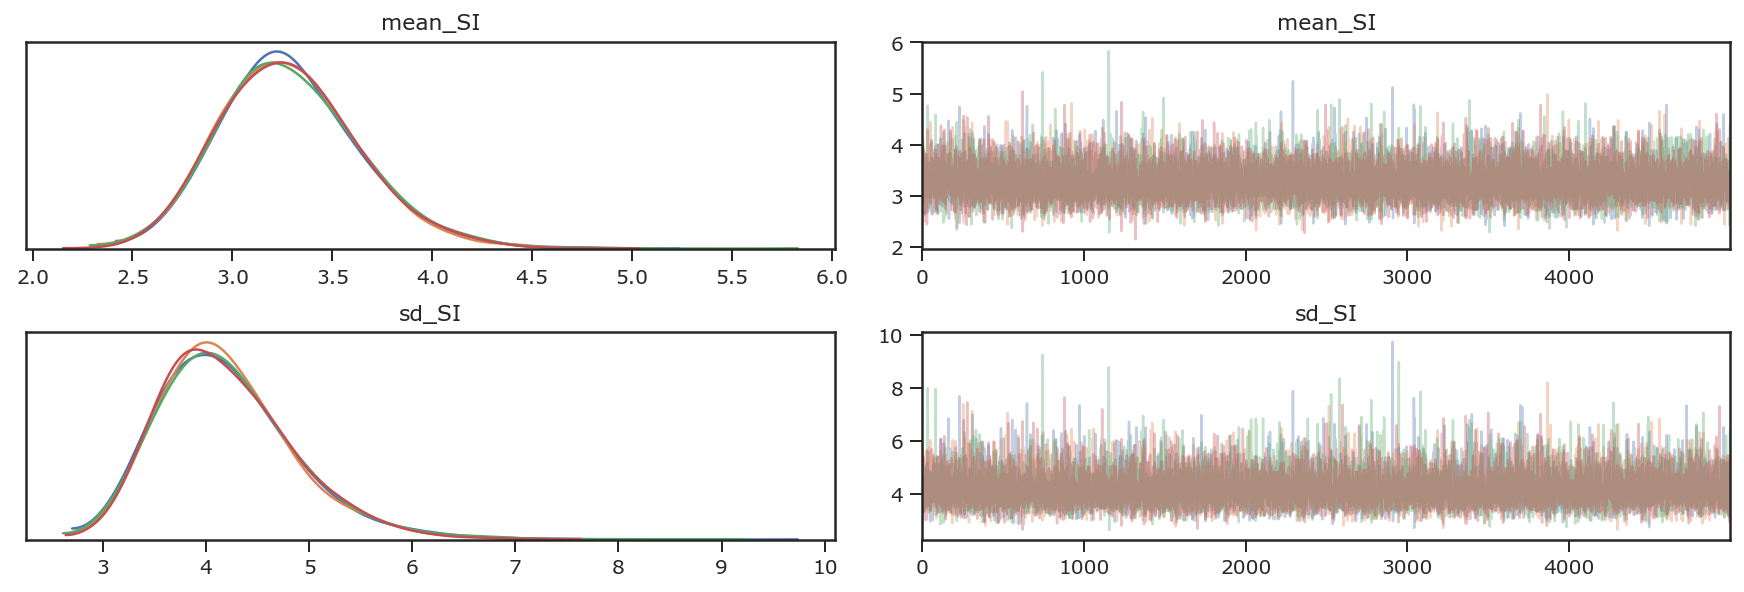

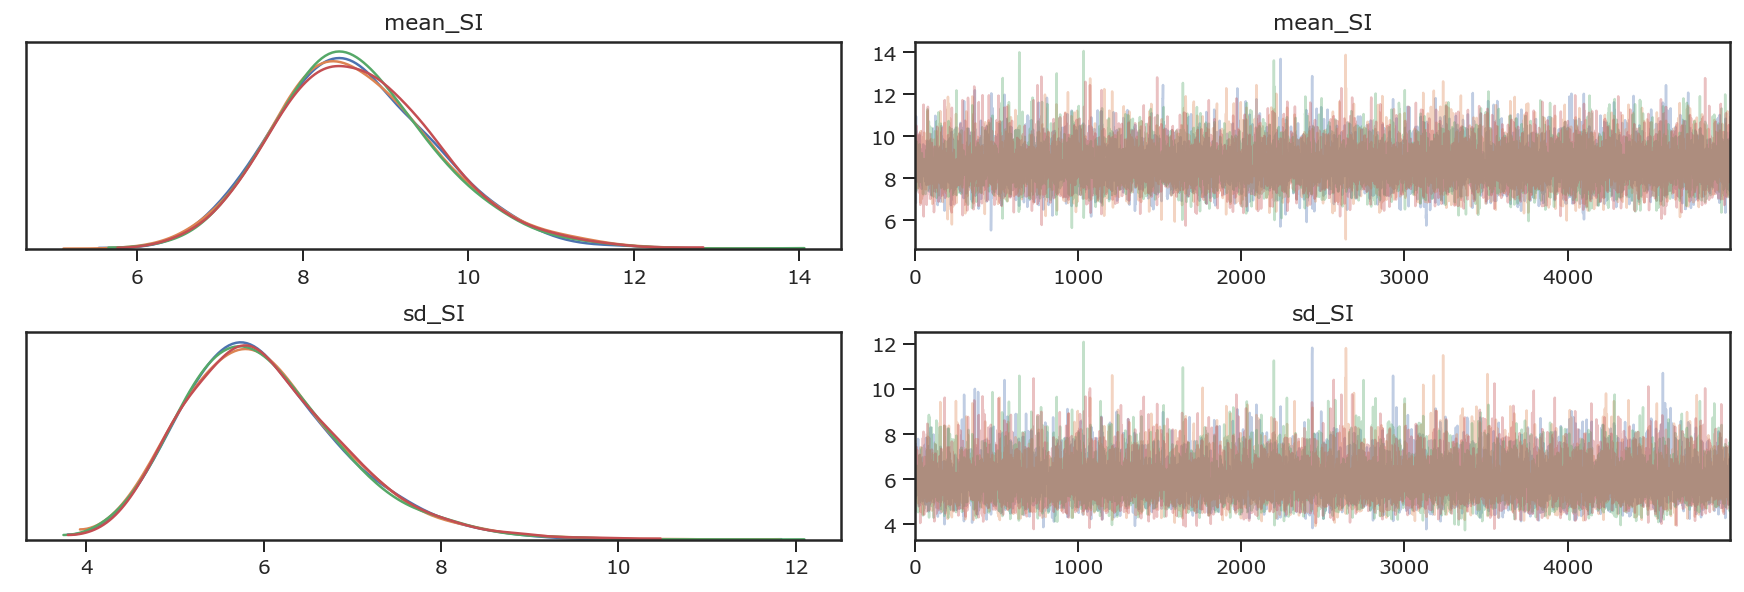

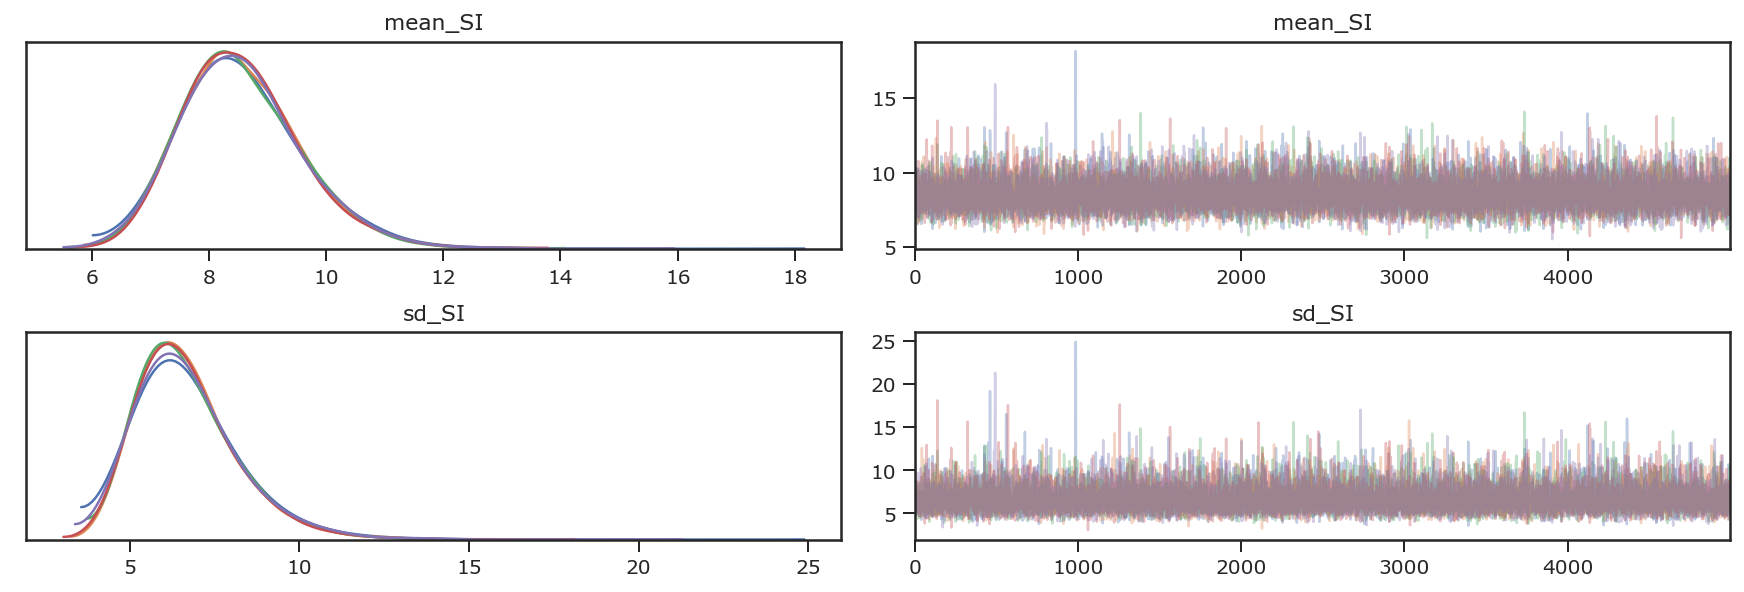

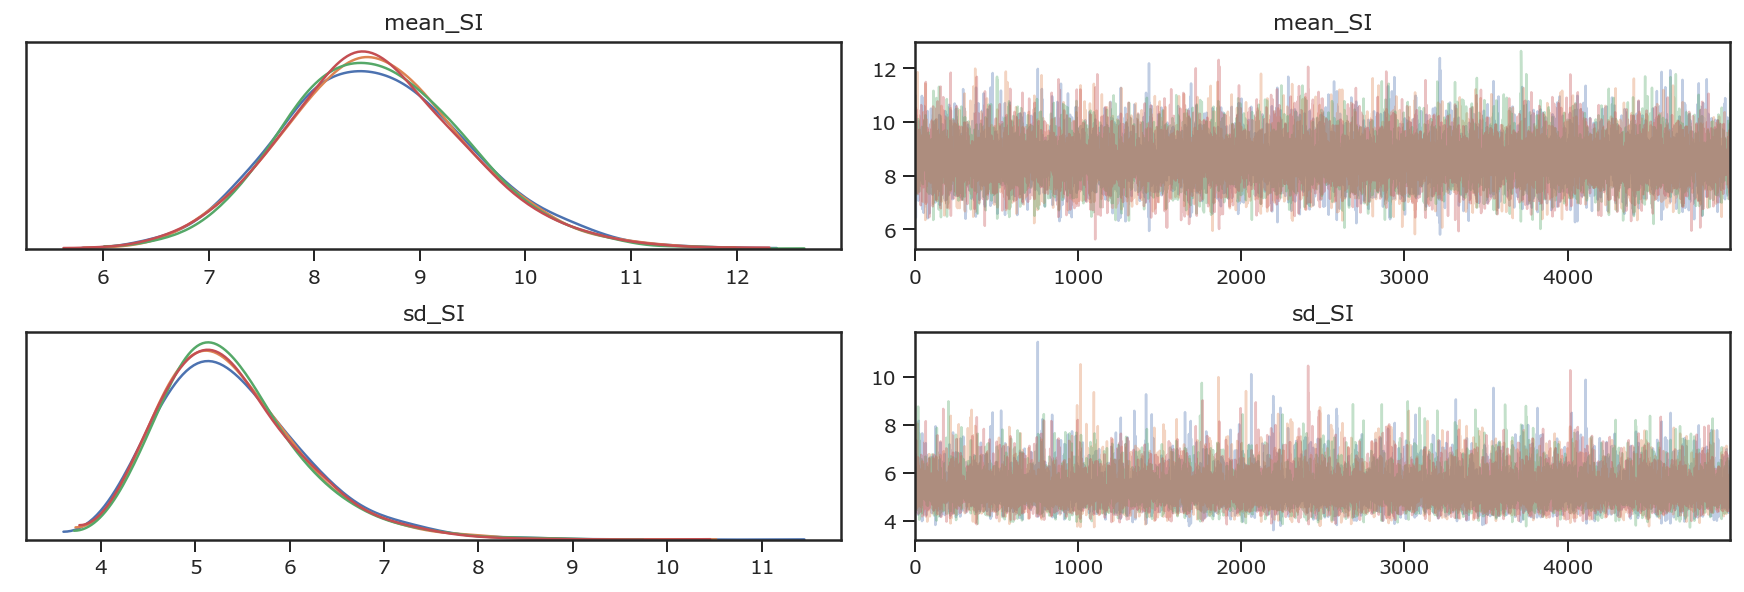

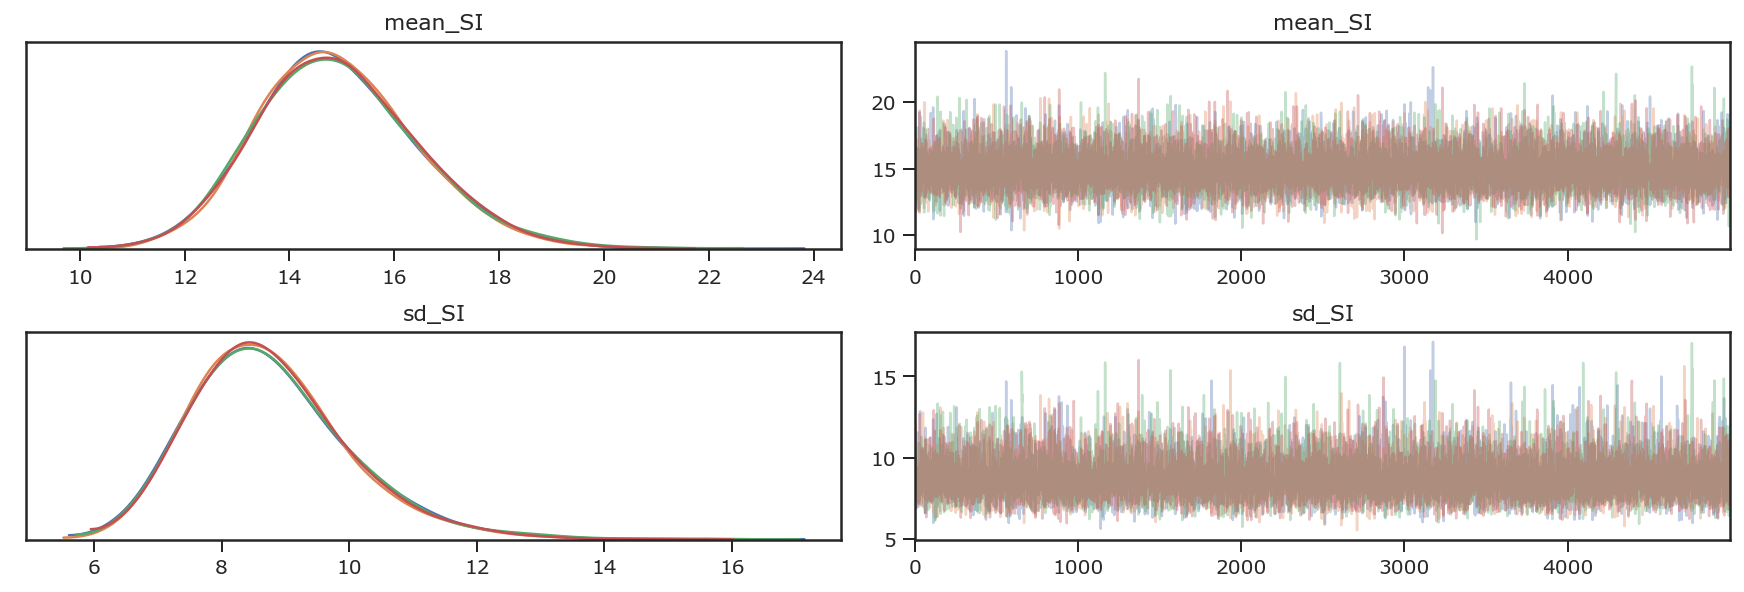

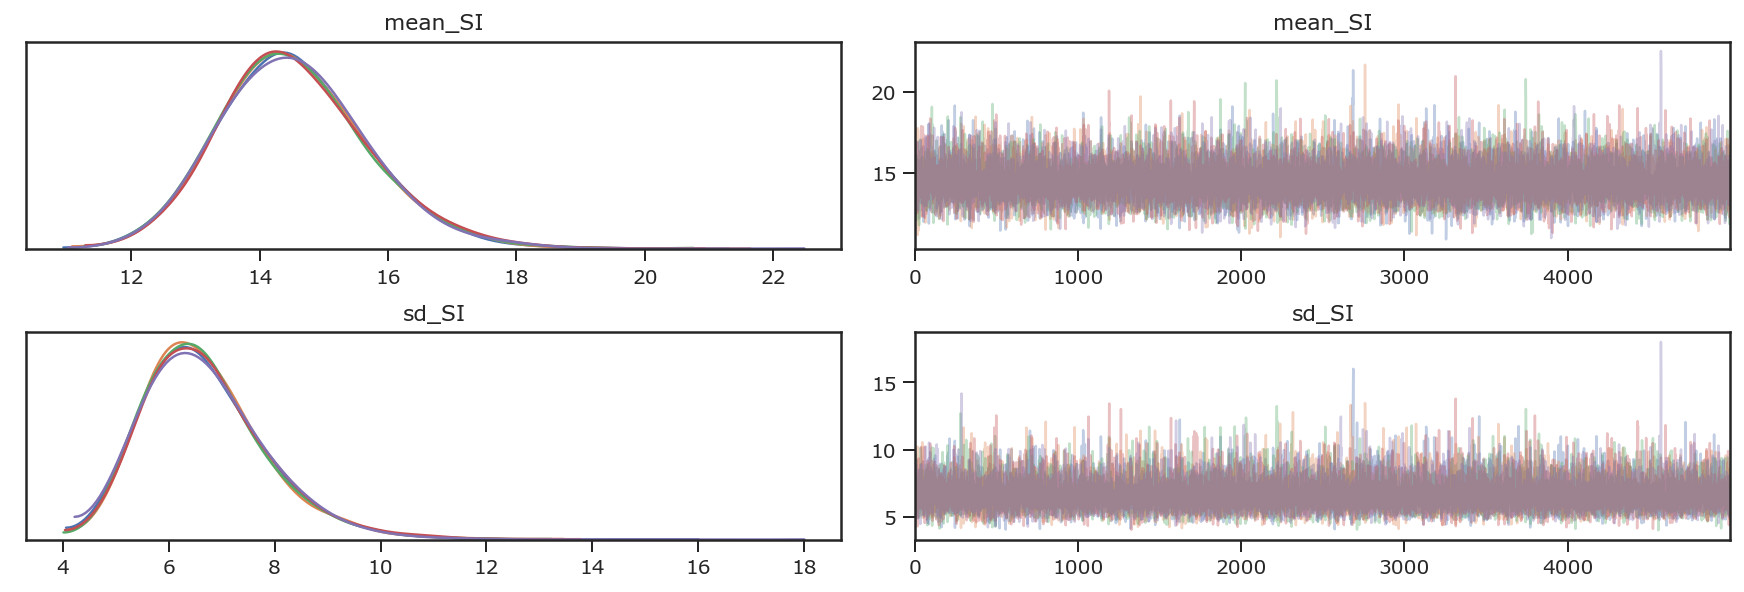

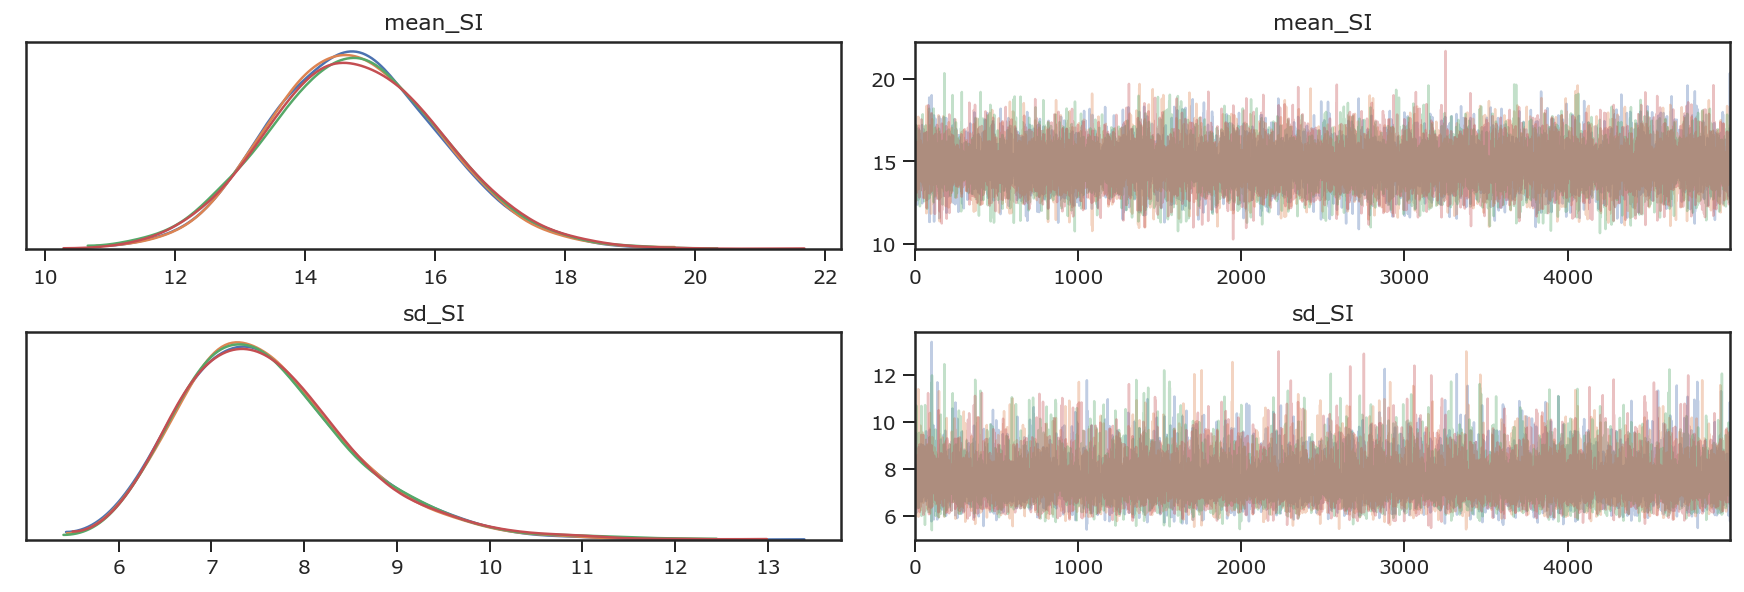

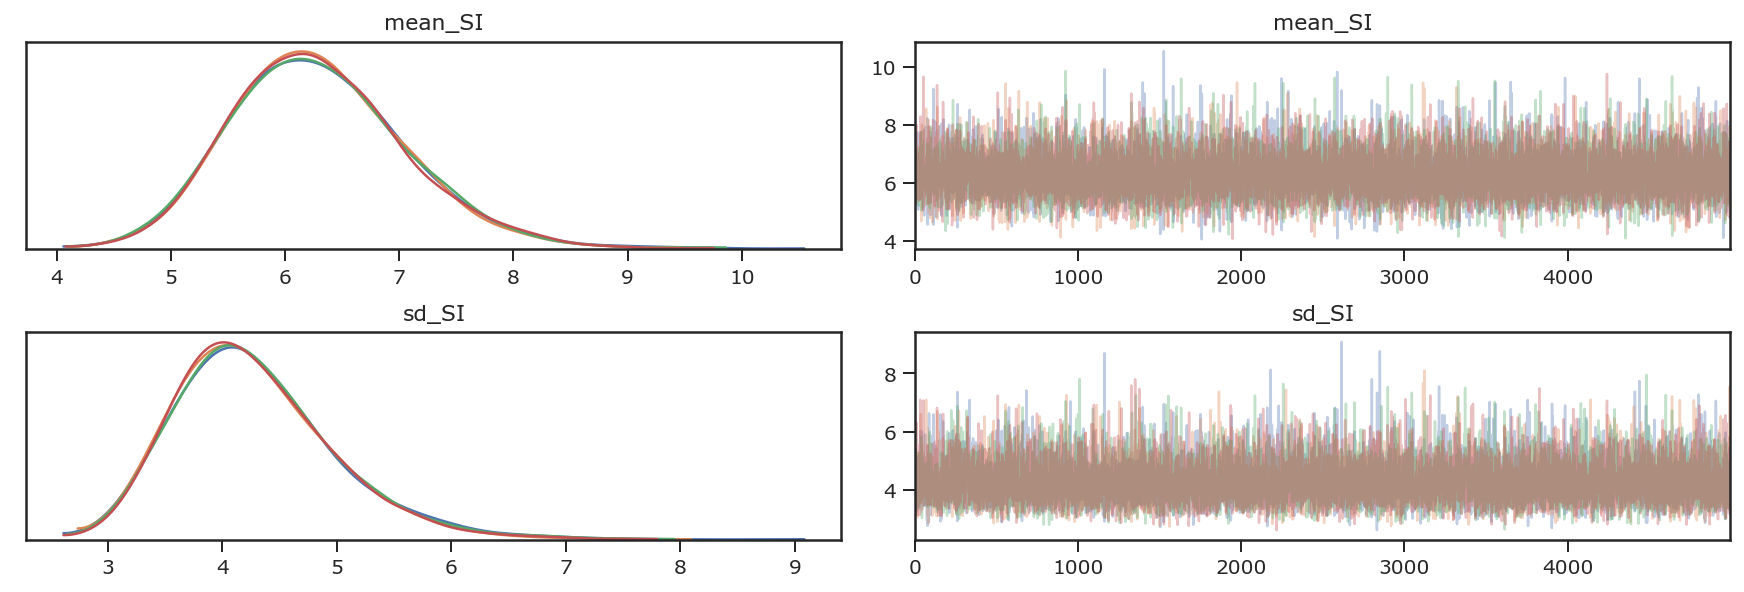

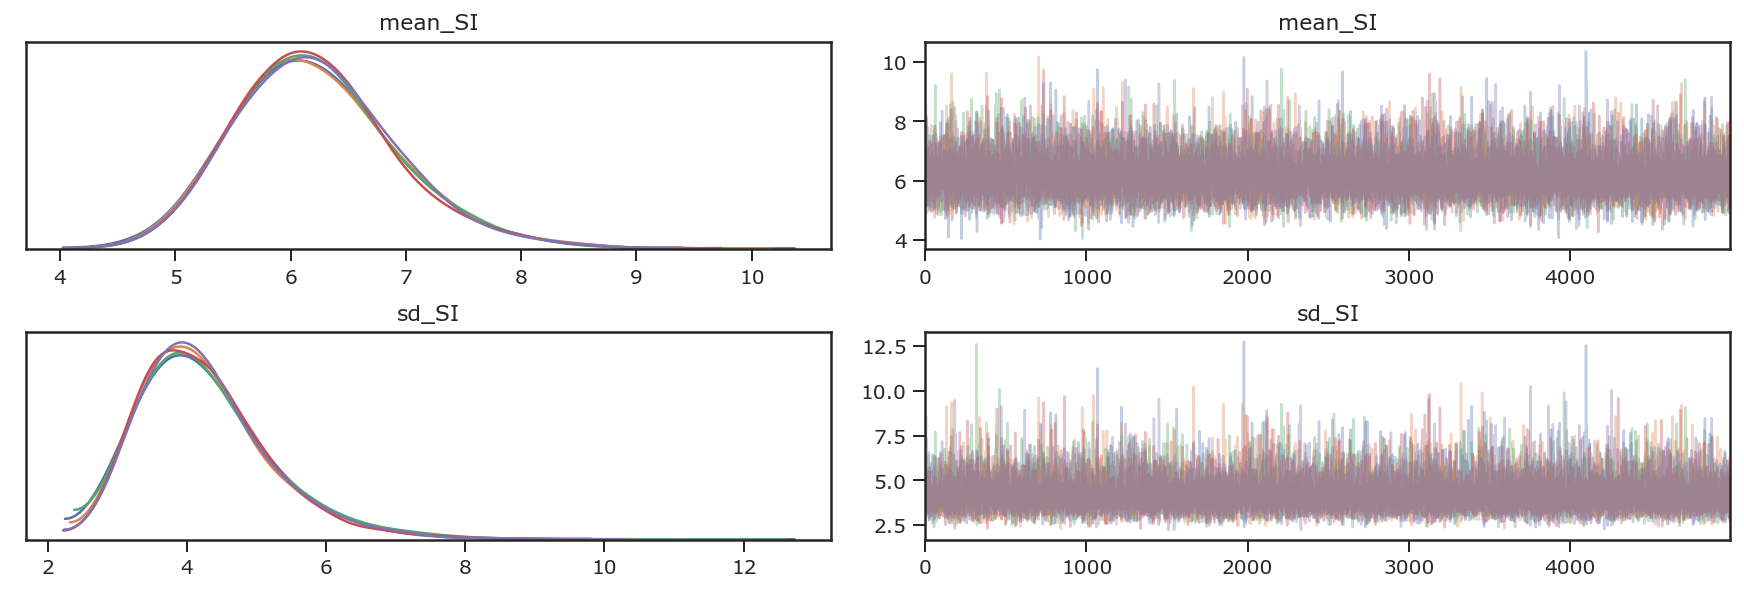

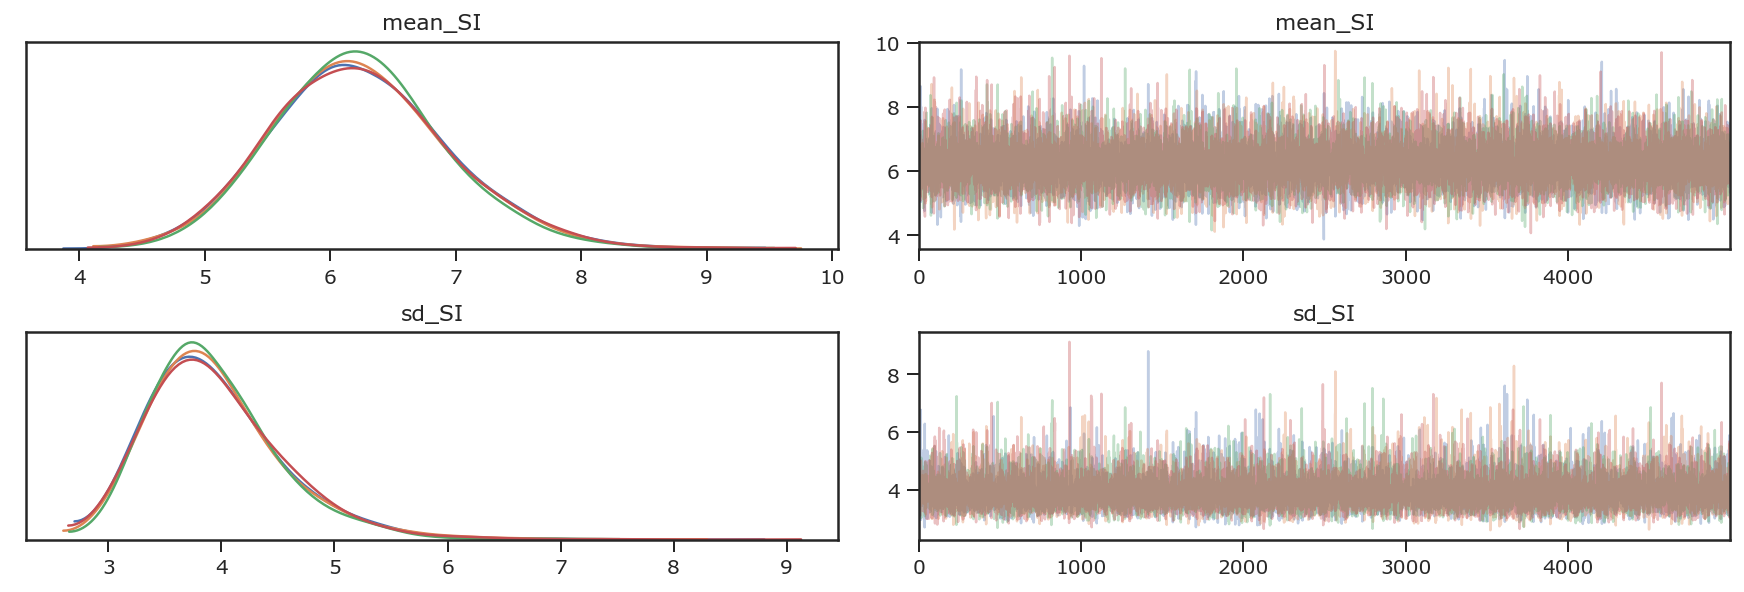

In [72]:
!mkdir -p ../../results/Stan-sims/traceplots
for truncation_type in ['no_truncation']:
    for idx0,dataset in enumerate(datasets):
        for idx, distrib in enumerate(distribs):
            folder = dataset+"-"+distrib+"-"+truncation_type
            print(colored(folder, 'red'))

            posterior_glob = !ls ../../results/Stan-sims/{folder}/trace-*

            cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
            param1 = cmdstan_data.posterior.param1.values.ravel()
            param2 = cmdstan_data.posterior.param2.values.ravel()
            cmdstan_stats = get_stats(cmdstan_data)  

            df_ = cmdstan_stats
            meanSI_ = df_.loc[lambda d: d['var']=='mean_SI',['mean','q2.5','q97.5']].values[0]
            sdSI_ = df_.loc[lambda d: d['var']=='sd_SI',['mean','q2.5','q97.5']].values[0]

            if distrib=='gamma':
                # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
                y = np.percentile(np.stack([ss.gamma(param1[idx],scale=1/param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
            elif distrib=='weibull':
                # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html
                y = np.percentile(np.stack([ss.weibull_min(param1[idx],scale=param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
            elif distrib=='lognormal':
                # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
                y = np.percentile(np.stack([ss.lognorm(param2[idx],scale=np.exp(param1[idx])).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
            output_ = [dataset,distrib,truncation_type,
                  '%.1f (%.1f, %.1f)'%(meanSI_[0],meanSI_[1],meanSI_[2]),
                  '%.1f (%.1f, %.1f)'%(sdSI_[0],sdSI_[1],sdSI_[2]),
                  '%.1f (%.1f, %.1f)'%(y[:,0][0],y[:,0][1],y[:,0][2]),
                  '%.1f (%.1f, %.1f)'%(y[:,1][0],y[:,1][1],y[:,1][2]), 
                  '%.1f (%.1f, %.1f)'%(y[:,2][0],y[:,2][1],y[:,2][2]), 
                  '%.1f (%.1f, %.1f)'%(y[:,3][0],y[:,3][1],y[:,3][2])]

            output = [output_] if idx==0 else np.r_[output, [output_]]
            print(output_)
            cmdstan_data_all = [cmdstan_data] if idx==0 else np.r_[cmdstan_data_all, cmdstan_data]

            az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
            plt.savefig("../../results/Stan-sims/traceplots/trace-"+folder+".pdf", format='pdf')

        output_df = pd.DataFrame(output,
                                 columns=['Dataset', 'Distribution', 'Truncation', 'mean', 
                                          'SD', 'q5', 'median', 'q95', 'q99'])

        models = dict([[distribs[idx], cmdstan_data_all[idx]] for idx in range(len(output))])
        stats_compare = az.compare(models)

        df_stats_compare = stats_compare.reset_index().rename(columns={'index': 'Distribution'})
        df_stats_compare = df_stats_compare.loc[:,['Distribution','waic','d_waic','weight']]

        Df_ = df_stats_compare.merge(output_df)
        Df_['waic'] = [round(x,1) for x in Df_['waic']]
        Df_['d_waic'] = [round(x,2) for x in Df_['d_waic']]
        Df_['weight'] = [round(x,3) for x in Df_['weight']]
        display(Df_)

        Df = pd.concat([Df, Df_]) if idx0 else Df_
        
    Df.to_excel('../../results/Stan-sims/summary-'+truncation_type+'.xlsx')

## Making the excel table

In [117]:
df = pd.read_excel("../../results/Stan-sims/summary-no_truncation.xlsx")
df.loc[lambda d: d.Dataset=='data_incper','Dataset'] = 'Incubation period excluding WR (days)'
df.loc[lambda d: d.Dataset=='data_incper_inclwuhan','Dataset'] = 'Incubation period including WR (days)'
df.loc[lambda d: d.Dataset=='data_ons_hosp','Dataset'] = 'Onset to hospitalization - living (days)'
df.loc[lambda d: d.Dataset=='dthdata_ons_hosp','Dataset'] = 'Onset to hospitalization - deceased (days)'
df.loc[lambda d: d.Dataset=='dthdata_ons_dth','Dataset'] = 'Onset to death (days)'
df.loc[lambda d: d.Dataset=='dthdata_hosp_dth','Dataset'] = 'Hospitalization to death (days)'
df.drop(['Unnamed: 0', 'd_waic'],1)
value_variables = ['mean','SD','q5','median','q95','q99','waic','weight']
df = pd.melt(df, id_vars=['Dataset','Distribution'], value_vars=value_variables)
df['variable'] = pd.Categorical(df['variable'],categories=value_variables)
df['Distribution'] = pd.Categorical(df['Distribution'],categories=['lognormal','weibull','gamma'])
df = df.pivot_table(index=['Distribution','variable'],columns='Dataset',values='value', aggfunc='first')
cols = df.columns.tolist()
df = df.loc[:,[cols[x] for x in [1,2,5,4,3,0]]]
df.to_excel("../../results/stan_summary-no_truncation.xlsx")
df

Dataset               Incubation period excluding WR (days)  \
Distribution variable                                         
lognormal    mean                            4.6 (3.8, 5.7)   
             SD                              3.9 (2.5, 6.4)   
             q5                              1.1 (0.6, 1.7)   
             median                          3.5 (2.7, 4.4)   
             q95                           11.5 (8.8, 16.3)   
             q99                          18.8 (13.1, 31.2)   
             waic                                       360   
             weight                                    0.55   
weibull      mean                            4.7 (3.7, 5.8)   
             SD                              4.2 (3.1, 6.1)   
             q5                              0.4 (0.1, 0.8)   
             median                          3.6 (2.5, 4.6)   
             q95                          12.7 (10.0, 17.6)   
             q99                          18.4 (13.9, 28.5)   
             waic                                     373.1   
             weight                                   0.001   
gamma        mean                            5.0 (4.1, 5.9)   
             SD                              3.5 (2.7, 4.6)   
             q5                              0.9 (0.5, 1.4)   
             median                          4.2 (3.3, 5.0)   
             q95                           11.6 (9.5, 14.6)   
             q99                          16.1 (13.0, 21.1)   
             waic                                     361.1   
             weight                                   0.448   

Dataset               Incubation period including WR (days)  \
Distribution variable                                         
lognormal    mean                            5.0 (4.4, 5.6)   
             SD                              2.9 (2.2, 3.8)   
             q5                              1.8 (1.4, 2.3)   
             median                          4.3 (3.8, 4.9)   
             q95                           10.4 (8.9, 12.5)   
             q99                          14.9 (12.1, 19.2)   
             waic                                     944.7   
             weight                                       1   
weibull      mean                            5.1 (4.5, 5.8)   
             SD                              3.2 (2.7, 3.8)   
             q5                              1.0 (0.6, 1.4)   
             median                          4.6 (3.9, 5.3)   
             q95                           11.0 (9.7, 12.8)   
             q99                          14.3 (12.3, 17.1)   
             waic                                     984.9   
             weight                                       0   
gamma        mean                            5.1 (4.5, 5.7)   
             SD                              3.1 (2.6, 3.8)   
             q5                              1.2 (0.8, 1.6)   
             median                          4.4 (3.8, 5.0)   
             q95                           11.0 (9.6, 12.9)   
             q99                          14.9 (12.8, 18.0)   
             waic                                     974.9   
             weight                                       0   

Dataset               Onset to hospitalization - living (days)  \
Distribution variable                                            
lognormal    mean                               3.8 (2.9, 5.1)   
             SD                                8.3 (4.9, 14.2)   
             q5                                 0.2 (0.1, 0.3)   
             median                             1.6 (1.2, 2.0)   
             q95                             13.6 (10.1, 19.2)   
             q99                             33.0 (22.4, 52.2)   
             waic                                        693.8   
             weight                                          0   
weibull      mean                               3.3 (2.7, 4.1)

# With truncation

In [310]:
!mkdir -p ../../results/Stan-sims/traceplots

dirs = !ls -d ../../results/Stan-sims/*data*truncated
print(colored("Only Lognormal",'red'))
print(colored(dirs,'green'))

idx = 0
for folder in dirs:
    dataset, distrib, truncation_type = folder.split("/")[-1].split("-")
    print(colored(folder, 'red'))

    posterior_glob = !ls ../../results/Stan-sims/{folder}/trace-*

    cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
    param1 = cmdstan_data.posterior.param1.values.ravel()
    param2 = cmdstan_data.posterior.param2.values.ravel()
    cmdstan_stats = get_stats(cmdstan_data)  

    df_ = cmdstan_stats
    meanSI_ = df_.loc[lambda d: d['var']=='mean_SI',['mean','q2.5','q97.5']].values[0]
    sdSI_ = df_.loc[lambda d: d['var']=='sd_SI',['mean','q2.5','q97.5']].values[0]
    #param1_ = df_.loc[lambda d: d['var']=='param1',['mean','q2.5','q97.5']].values[0]
    #param2_ = df_.loc[lambda d: d['var']=='param2',['mean','q2.5','q97.5']].values[0]

    y = np.percentile(np.stack([ss.lognorm(param2[idx],scale=np.exp(param1[idx])).ppf([.05,.5,.95,.99]).tolist() for idx in range(7500)]).T,[50,2.5,97.5],axis=1)
    output_ = [dataset,distrib,truncation_type,
          '%.1f (%.1f, %.1f)'%(meanSI_[0],meanSI_[1],meanSI_[2]),
          '%.1f (%.1f, %.1f)'%(sdSI_[0],sdSI_[1],sdSI_[2]),
          #'%.3f (%.3f, %.3f)'%(param1_[0],param1_[1],param1_[2]),
          #'%.3f (%.3f, %.3f)'%(param2_[0],param2_[1],param2_[2]),
          '%.1f (%.1f, %.1f)'%(y[:,0][0],y[:,0][1],y[:,0][2]),
          '%.1f (%.1f, %.1f)'%(y[:,1][0],y[:,1][1],y[:,1][2]), 
          '%.1f (%.1f, %.1f)'%(y[:,2][0],y[:,2][1],y[:,2][2]), 
          '%.1f (%.1f, %.1f)'%(y[:,3][0],y[:,3][1],y[:,3][2])]

    output = [output_] if idx==0 else np.r_[output, [output_]]
    print(output_)
    cmdstan_data_all = [cmdstan_data] if idx==0 else np.r_[cmdstan_data_all, cmdstan_data]
    idx += 1

output_df = pd.DataFrame(output, columns=['Dataset', 'Distribution', 'Truncation', 'mean', 'SD', 
                                          #'param1', 'param2', 
                                          'q5', 'median', 'q95', 'q99'])

display(output_df)

Only Lognormal
['../../results/Stan-sims/data_incper-lognormal-truncated', '../../results/Stan-sims/data_ons_hosp-lognormal-truncated', '../../results/Stan-sims/dthdata_hosp_dth-lognormal-truncated', '../../results/Stan-sims/dthdata_ons_dth-lognormal-truncated', '../../results/Stan-sims/dthdata_ons_hosp-lognormal-truncated']
../../results/Stan-sims/data_incper-lognormal-truncated
['data_incper', 'lognormal', 'truncated', '5.4 (4.1, 7.4)', '5.7 (3.0, 11.6)', '1.307 (1.018, 1.559)', '0.841 (0.596, 1.160)', '1.0 (0.5, 1.6)', '3.7 (2.8, 4.8)', '14.4 (10.1, 24.3)', '25.3 (15.6, 52.5)']
../../results/Stan-sims/data_ons_hosp-lognormal-truncated
['data_ons_hosp', 'lognormal', 'truncated', '9.7 (5.4, 17.0)', '35.2 (12.9, 84.5)', '0.967 (0.623, 1.339)', '1.582 (1.342, 1.830)', '0.2 (0.1, 0.3)', '2.6 (1.9, 3.8)', '35.1 (20.5, 65.0)', '102.8 (52.8, 218.4)']
../../results/Stan-sims/dthdata_hosp_dth-lognormal-truncated
['dthdata_hosp_dth', 'lognormal', 'truncated', '12.8 (8.6, 20.2)', '12.3 (6.3, 24

Dataset Distribution Truncation               mean  \
0       data_incper    lognormal  truncated     5.4 (4.1, 7.4)   
1     data_ons_hosp    lognormal  truncated    9.7 (5.4, 17.0)   
2  dthdata_hosp_dth    lognormal  truncated   12.8 (8.6, 20.2)   
3   dthdata_ons_dth    lognormal  truncated  19.9 (14.9, 29.0)   
4  dthdata_ons_hosp    lognormal  truncated     6.6 (5.2, 8.8)   

                  SD                param1                param2  \
0    5.7 (3.0, 11.6)  1.307 (1.018, 1.559)  0.841 (0.596, 1.160)   
1  35.2 (12.9, 84.5)  0.967 (0.623, 1.339)  1.582 (1.342, 1.830)   
2   12.3 (6.3, 24.5)  2.211 (1.896, 2.589)  0.785 (0.615, 0.992)   
3   11.4 (6.5, 21.6)  2.838 (2.595, 3.168)  0.520 (0.397, 0.684)   
4     4.8 (3.0, 8.5)  1.660 (1.424, 1.903)  0.647 (0.496, 0.856)   

               q5             median                q95                  q99  
0  1.0 (0.5, 1.6)     3.7 (2.8, 4.8)  14.4 (10.1, 24.3)    25.3 (15.6, 52.5)  
1  0.2 (0.1, 0.3)     2.6 (1.9, 3.8)  35.1 (20.5, 65.0)  102.8 (52.8, 218.4)  
2  2.5 (1.7, 3.5)    9.0 (6.7, 13.1)  32.4 (20.6, 59.3)   55.0 (31.9, 114.7)  
3  7.3 (5.6, 9.3)  16.8 (13.4, 23.7)  39.1 (27.7, 69.3)   55.3 (36.6, 109.0)  
4  1.8 (1.2, 2.5)     5.3 (4.2, 6.7)  14.9 (11.1, 23.8)    23.0 (16.0, 42.0)

In [109]:
output_df.to_excel('../../results/Stan-sims/summary-truncated.xlsx')

## Making the excel table

In [116]:
df = pd.read_excel("../../results/Stan-sims/summary-truncated.xlsx")
df.loc[lambda d: d.Dataset=='data_incper','Dataset'] = 'Incubation period excluding WR (days)'
df.loc[lambda d: d.Dataset=='data_incper_inclwuhan','Dataset'] = 'Incubation period including WR (days)'
df.loc[lambda d: d.Dataset=='data_ons_hosp','Dataset'] = 'Onset to hospitalization - living (days)'
df.loc[lambda d: d.Dataset=='dthdata_ons_hosp','Dataset'] = 'Onset to hospitalization - deceased (days)'
df.loc[lambda d: d.Dataset=='dthdata_ons_dth','Dataset'] = 'Onset to death (days)'
df.loc[lambda d: d.Dataset=='dthdata_hosp_dth','Dataset'] = 'Hospitalization to death (days)'
value_variables = ['mean','SD','q5','median','q95','q99']
df = pd.melt(df, id_vars=['Dataset','Distribution'], value_vars=value_variables)
df['variable'] = pd.Categorical(df['variable'],categories=value_variables)
df['Distribution'] = pd.Categorical(df['Distribution'],categories=['lognormal','weibull','gamma'])
df = df.pivot_table(index=['Distribution','variable'],columns='Dataset',values='value', aggfunc='first')
cols = df.columns.tolist()
# df = df.loc[:,[cols[x] for x in [1,2,5,4,3,0]]]
df.to_excel("../../results/stan_summary-truncated.xlsx")
df

Dataset               Hospitalization to death (days)  \
Distribution variable                                   
lognormal    mean                    12.8 (8.6, 20.2)   
             SD                      12.3 (6.3, 24.5)   
             q5                        2.5 (1.7, 3.5)   
             median                   9.0 (6.7, 13.1)   
             q95                    32.4 (20.6, 59.3)   
             q99                   55.0 (31.9, 114.7)   

Dataset               Incubation period excluding WR (days)  \
Distribution variable                                         
lognormal    mean                            5.4 (4.1, 7.4)   
             SD                             5.7 (3.0, 11.6)   
             q5                              1.0 (0.5, 1.6)   
             median                          3.7 (2.8, 4.8)   
             q95                          14.4 (10.1, 24.3)   
             q99                          25.3 (15.6, 52.5)   

Dataset               Onset to death (days)  \
Distribution variable                         
lognormal    mean         19.9 (14.9, 29.0)   
             SD            11.4 (6.5, 21.6)   
             q5              7.3 (5.6, 9.3)   
             median       16.8 (13.4, 23.7)   
             q95          39.1 (27.7, 69.3)   
             q99         55.3 (36.6, 109.0)   

Dataset               Onset to hospitalization - deceased (days)  \
Distribution variable                                              
lognormal    mean                                 6.6 (5.2, 8.8)   
             SD                                   4.8 (3.0, 8.5)   
             q5                                   1.8 (1.2, 2.5)   
             median                               5.3 (4.2, 6.7)   
             q95                               14.9 (11.1, 23.8)   
             q99                               23.0 (16.0, 42.0)   

Dataset               Onset to hospitalization - living (days)  
Distribution variable                                           
lognormal    mean                              9.7 (5.4, 17.0)  
             SD                              35.2 (12.9, 84.5)  
             q5                                 0.2 (0.1, 0.3)  
             median                             2.6 (1.9, 3.8)  
             q95                             35.1 (20.5, 65.0)  
             q99                           102.8 (52.8, 218.4)

# Generating figures

../../results/Stan-sims/data_incper-lognormal-no_truncation
../../results/Stan-sims/data_incper_inclwuhan-lognormal-no_truncation
../../results/Stan-sims/data_incper-lognormal-truncated


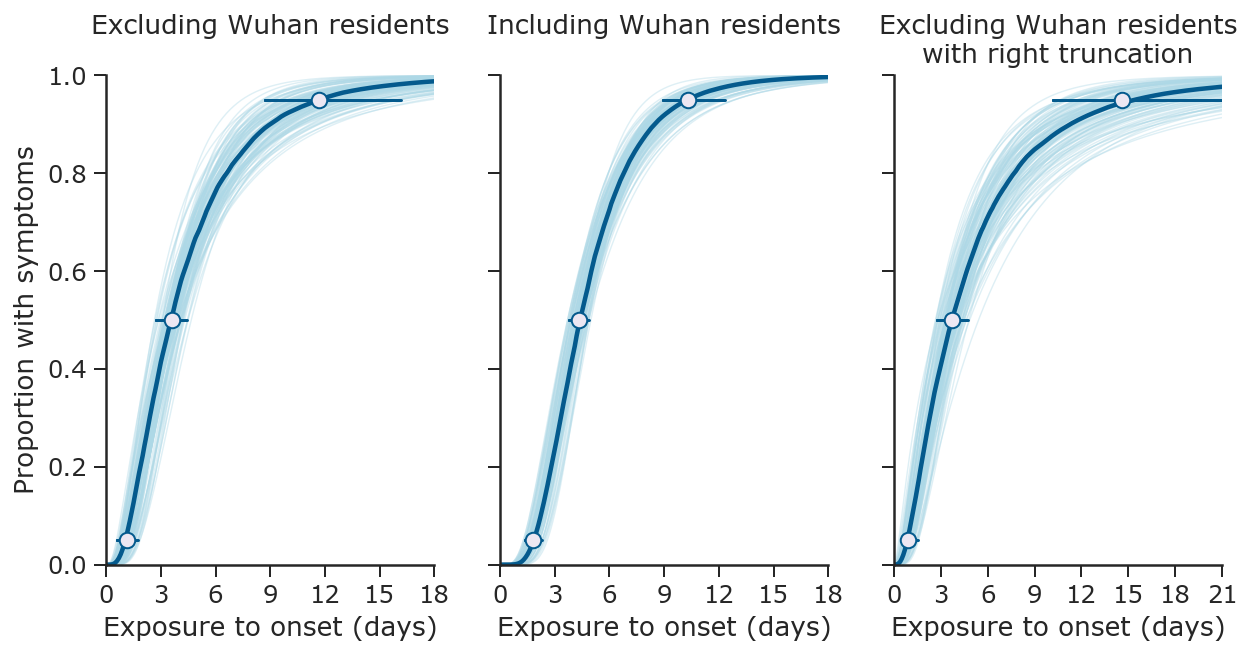

In [249]:
folders = ["../../results/Stan-sims/data_incper-lognormal-no_truncation", 
           "../../results/Stan-sims/data_incper_inclwuhan-lognormal-no_truncation",
           "../../results/Stan-sims/data_incper-lognormal-truncated"]
dataset, distrib, truncation_type = folder.split("/")[-1].split("-")

fig, axs = plt.subplots(1,3,sharey=True)
fig.set_size_inches(10,4.5)
clrs = ['lightblue','#045a8d','#045a8d','#ece7f2']
xstep = .1
xmax = 18

ttls = ['Excluding Wuhan residents\n', 'Including Wuhan residents\n',
        'Excluding Wuhan residents\nwith right truncation']

for i in range(3):
    folder = folders[i]
    ax = axs[i]
    if i==2:
        xmax = 21

    dataset, distrib, truncation_type = folder.split("/")[-1].split("-")
    
    print(colored(folder, 'red'))

    posterior_glob = !ls ./{folder}/trace-*

    cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
    param1 = cmdstan_data.posterior.param1.values.ravel()
    param2 = cmdstan_data.posterior.param2.values.ravel()

    Yp = np.percentile(np.stack([ss.lognorm(param2[idx],scale=np.exp(param1[idx])).ppf([.05,.5,.95,.99]).tolist() for idx in range(1000)]).T,[50,2.5,97.5],axis=1)

    x = np.arange(0,xmax+xstep,xstep)
    Y = np.percentile(np.stack([[ss.lognorm(param2[idx],scale=np.exp(param1[idx])).cdf(xx) for xx in x] for idx in range(1000)]).T, [50], axis=1)[0]

    for idx in range(120):
        distr = ss.lognorm(param2[idx],scale=np.exp(param1[idx]))
        y = [distr.cdf(xx) for xx in x]
        ax.plot(x, y, lw=.7, color=clrs[0], alpha=.4)

    ax.plot(x, Y, lw=2.25, color=clrs[1])

    ax.plot(Yp[:,0], [.05]*3, lw=1.5, color=clrs[2])
    ax.plot(Yp[:,1], [.5]*3, lw=1.5, color=clrs[2])
    ax.plot(Yp[:,2], [.95]*3, lw=1.5, color=clrs[2])
    ax.scatter(Yp[0,:3], [.05, .5, .95], s=60, edgecolors=clrs[1], facecolor=clrs[3], zorder=4)

    ax.set_xlim(0,xmax); ax.set_ylim(0,1)
    xtks = np.arange(0,xmax+3,3); ax.set_xticks(xtks); 

    ax.set_title(ttls[i])
    ax.set_xlabel('Exposure to onset (days)')
    if(i==0):
        ax.set_ylabel('Proportion with symptoms')

    ax.spines['left'].set_bounds(0,1)
    ax.spines['bottom'].set_bounds(0,xmax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False);

my_dpi = 300
!mkdir -p ../../figures
plt.savefig("../../figures/Figure1.pdf",
            format='pdf',
            figsize=(2*3.54331/my_dpi, 5/my_dpi), dpi=my_dpi);

../../results/Stan-sims/data_ons_hosp-gamma-no_truncation
../../results/Stan-sims/dthdata_ons_hosp-gamma-no_truncation
CPU times: user 6min 6s, sys: 9.72 s, total: 6min 16s
Wall time: 6min 3s


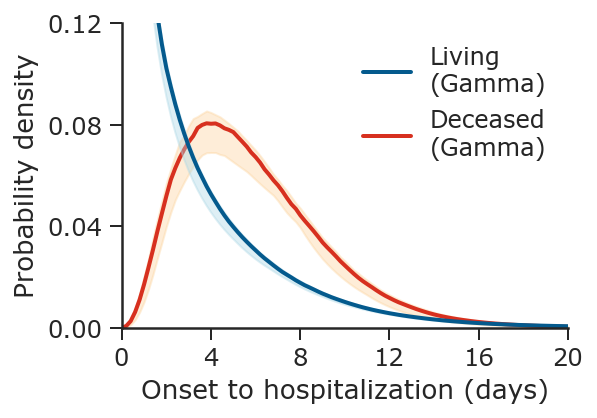

In [302]:
%%time
folders = ["../../results/Stan-sims/data_ons_hosp-gamma-no_truncation", 
           "../../results/Stan-sims/dthdata_ons_hosp-gamma-no_truncation"]
dataset, distrib, truncation_type = folder.split("/")[-1].split("-")

fig, ax = plt.subplots()
fig.set_size_inches(4,2.8)
xstep = .2
xmax = 20
ymax = 0.12
x = np.arange(.01,xmax+xstep,xstep)

clrs = ['#045a8d','lightblue','#d7301f','#fdd49e']

lbls = ['Living\n(Gamma)', 'Deceased\n(Gamma)']

for i in range(2):
    folder = folders[i]

    dataset, distrib, truncation_type = folder.split("/")[-1].split("-")
    
    print(colored(folder, 'red'))

    posterior_glob = !ls ./{folder}/trace-*

    cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
    param1 = cmdstan_data.posterior.param1.values.ravel()
    param2 = cmdstan_data.posterior.param2.values.ravel()
    
    if distrib=='gamma':
        yy = np.stack([[ss.gamma(param1[idx],scale=1/param2[idx]).pdf(xx) for xx in x] for idx in range(2500)]).T
    elif distrib=='weibull':
        yy = np.stack([[ss.weibull_min(param1[idx],scale=param2[idx]).pdf(xx) for xx in x] for idx in range(2500)]).T
    elif distrib=='lognormal':
        yy = np.stack([[ss.lognorm(param2[idx],scale=np.exp(param1[idx])).pdf(xx) for xx in x] for idx in range(2500)]).T
        
    Ylower = np.percentile(yy,[.025],axis=1)[0]
    Yupper = np.percentile(yy,[.975],axis=1)[0]
    Y = np.percentile(yy,[.50],axis=1)[0]
    ax.plot(x, Y, lw=2, color=clrs[2*i], label=lbls[i], zorder=-2*i-3)
    ax.fill_between(x, Ylower, Yupper, color=clrs[2*i+1], alpha=.4, zorder=-2*i-4)


ax.set_xlim(0,xmax); ax.set_ylim(0,ymax); ax.set_yticks([0,.04,.08,.12])
xtks = np.arange(0,xmax+4,4); ax.set_xticks(xtks); 

ax.set_xlabel('Onset to hospitalization (days)')
ax.set_ylabel('Probability density')

ax.spines['left'].set_bounds(0,ymax)
ax.spines['bottom'].set_bounds(0,xmax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

ax.legend(fontsize=12,frameon=False)

my_dpi = 300
!mkdir -p ../../figures
plt.savefig("../../figures/Figure1A.pdf",
            format='pdf',
            bbox_inches='tight',
            figsize=(1.4*3.54331/my_dpi, 3.4/my_dpi), dpi=my_dpi);

../../results/Stan-sims/dthdata_ons_dth-lognormal-no_truncation
CPU times: user 3min 18s, sys: 2.88 s, total: 3min 21s
Wall time: 3min 17s


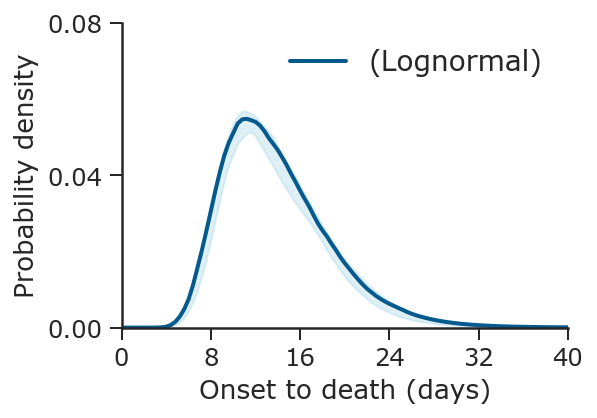

In [303]:
%%time
folder = "../../results/Stan-sims/dthdata_ons_dth-lognormal-no_truncation"
dataset, distrib, truncation_type = folder.split("/")[-1].split("-")

fig, ax = plt.subplots()
fig.set_size_inches(4,2.8)
xstep = .4
xmax = 40
ymax = 0.08
x = np.arange(.01,xmax+xstep,xstep)

dataset, distrib, truncation_type = folder.split("/")[-1].split("-")

print(colored(folder, 'red'))

posterior_glob = !ls ./{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()

if distrib=='gamma':
    yy = np.stack([[ss.gamma(param1[idx],scale=1/param2[idx]).pdf(xx) for xx in x] for idx in range(2500)]).T
elif distrib=='weibull':
    yy = np.stack([[ss.weibull_min(param1[idx],scale=param2[idx]).pdf(xx) for xx in x] for idx in range(2500)]).T
elif distrib=='lognormal':
    yy = np.stack([[ss.lognorm(param2[idx],scale=np.exp(param1[idx])).pdf(xx) for xx in x] for idx in range(2500)]).T

Ylower = np.percentile(yy,[.025],axis=1)[0]
Yupper = np.percentile(yy,[.975],axis=1)[0]
Y = np.percentile(yy,[.50],axis=1)[0]
ax.plot(x, Y, lw=2, color=clrs[0], label="(Lognormal)")
ax.fill_between(x, Ylower, Yupper, color=clrs[1], alpha=.4, zorder=-5)


ax.set_xlim(0,xmax); ax.set_ylim(0,ymax); ax.set_yticks([0,.04,.08])
xtks = np.arange(0,xmax+8,8); ax.set_xticks(xtks); 

ax.set_xlabel('Onset to death (days)')
ax.set_ylabel('Probability density')

ax.spines['left'].set_bounds(0,ymax)
ax.spines['bottom'].set_bounds(0,xmax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

ax.legend(frameon=False)

my_dpi = 300
!mkdir -p ../../figures
plt.savefig("../../figures/Figure1B.pdf",
            format='pdf',
            bbox_inches='tight',
            figsize=(1.4*3.54331/my_dpi, 3.4/my_dpi), dpi=my_dpi);

../../results/Stan-sims/dthdata_hosp_dth-weibull-no_truncation
CPU times: user 2min 16s, sys: 3.44 s, total: 2min 20s
Wall time: 2min 15s


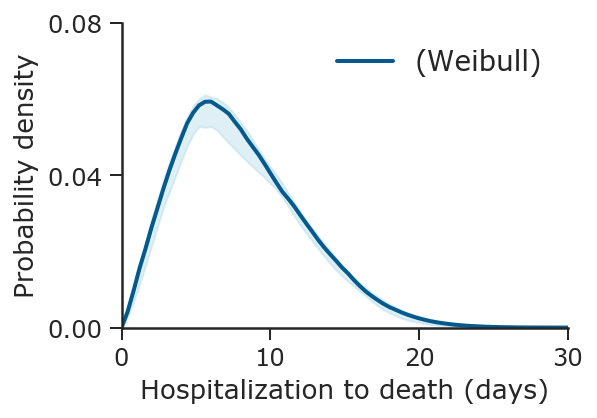

In [304]:
%%time
folder = "../../results/Stan-sims/dthdata_hosp_dth-weibull-no_truncation"
dataset, distrib, truncation_type = folder.split("/")[-1].split("-")

fig, ax = plt.subplots()
fig.set_size_inches(4,2.8)
xstep = .4
xmax = 30
ymax = 0.08
x = np.arange(.01,xmax+xstep,xstep)

dataset, distrib, truncation_type = folder.split("/")[-1].split("-")

print(colored(folder, 'red'))

posterior_glob = !ls ./{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()

if distrib=='gamma':
    yy = np.stack([[ss.gamma(param1[idx],scale=1/param2[idx]).pdf(xx) for xx in x] for idx in range(2500)]).T
elif distrib=='weibull':
    yy = np.stack([[ss.weibull_min(param1[idx],scale=param2[idx]).pdf(xx) for xx in x] for idx in range(2500)]).T
elif distrib=='lognormal':
    yy = np.stack([[ss.lognorm(param2[idx],scale=np.exp(param1[idx])).pdf(xx) for xx in x] for idx in range(2500)]).T

Ylower = np.percentile(yy,[.025],axis=1)[0]
Yupper = np.percentile(yy,[.975],axis=1)[0]
Y = np.percentile(yy,[.50],axis=1)[0]
ax.plot(x, Y, lw=2, color=clrs[0], label="(Weibull)")
ax.fill_between(x, Ylower, Yupper, color=clrs[1], alpha=.4, zorder=-5)


ax.set_xlim(0,xmax); ax.set_ylim(0,ymax); ax.set_yticks([0,.04,.08])
xtks = np.arange(0,xmax+10,10); ax.set_xticks(xtks); 

ax.set_xlabel('Hospitalization to death (days)')
ax.set_ylabel('Probability density')

ax.spines['left'].set_bounds(0,ymax)
ax.spines['bottom'].set_bounds(0,xmax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

ax.legend(frameon=False)

my_dpi = 300
!mkdir -p ../../figures
plt.savefig("../../figures/Figure1C.pdf",
            format='pdf',
            bbox_inches='tight',
            figsize=(1.4*3.54331/my_dpi, 3.4/my_dpi), dpi=my_dpi);